<div class='bar_title'></div>

*Smart Cities and Geospatial Data Analysis*

# Final Assignment

Gunther Gust / Ignacio Ubeda<br>
Chair for Enterprise AI

Winter Semester 23/24

**Sonia Bronner, Mat: 2654329 (github: soniabronner)**

In [1]:
import os
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
import esda
from pysal.lib import weights
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation
)
import numpy as np

from pysal.viz import mapclassify
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

/home/vscode/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_1097/3803805421.py:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly 

## Part I - Spatial Autocorrelation on San Diego Census Tracts (ACS 2017)

### Goal

Understanding how age and population concentrate across the metro area using global and local spatial statistics

### Data and Preparation

- 628 census tracts; selected the Median Age and Total Population from the ACS 2017 tract file
- Built a Queen-contiguity spatial weights matrix and row-standardised it to support PySAL analyses

### Methods

- Global Moran’s I to quantify spatial autocorrelation
- Local Indicators of Spatial Association (LISA) to map hot/cold spots and outliers (HH/LL/HL/LH)

### Findings

- **Median age** clusters: many LL (younger median age) clusters concentrate in core urban areas; HH (older median age) clusters appear along coastal/nature-adjacent tracts—consistent with amenity-driven settlement patterns
- **Population**: higher totals concentrate around select northern/urban pockets; widespread low counts across eastern/nature areas, including Anza-Borrego; visualized via choropleths + LISA

### Outputs

Choropleths, Moran scatterplots, and LISA cluster maps suitable for reporting

---------

**San Diego Tracts**

This dataset contains an extract of a set of variables from the 2017 ACS
Census Tracts for the San Diego (CA) metropolitan area

First, I will load my chosen dataset and check all the important data about it for better understanding:

I start by reading the file of my chosen dataset and store it in a "sandiego" variable

In [2]:
filepath = os.path.join('data', 'sandiego_tracts.gpkg')
sandiego = gpd.read_file(filepath, sep =',')

To check and make sure that my dataset is a geodataframe, I print out its type and the result confirms me that "sandiego" is a geodataframe

In [3]:
print(type(sandiego))

<class 'geopandas.geodataframe.GeoDataFrame'>


Now I will check the shape of my dataset to get a quick overall sense of its size. The code returns the number of rows and columns in the dataset

In [4]:
print(sandiego.shape)

(628, 25)


I can see, "sandiego" has 628 rows and 35 columns

For more information and better understanding of the dataset, I print out its info which provides me with a summary of the dataset

In [5]:
sandiego.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   GEOID                628 non-null    object  
 1   median_age           628 non-null    float64 
 2   total_pop            628 non-null    float64 
 3   total_pop_white      628 non-null    float64 
 4   tt_work              628 non-null    float64 
 5   hh_total             628 non-null    float64 
 6   hh_female            628 non-null    float64 
 7   total_bachelor       628 non-null    float64 
 8   median_hh_income     628 non-null    float64 
 9   income_gini          628 non-null    float64 
 10  total_housing_units  628 non-null    float64 
 11  total_rented         628 non-null    float64 
 12  median_no_rooms      628 non-null    float64 
 13  median_house_value   628 non-null    float64 
 14  NAME                 628 non-null    object  
 15  state          

The output shows me all the columns, their non-null values and datatypes of the dataset.
This helps me in quickly and concisely understaning the structure of "sandiego"

I also print out the first 5 rows of my dataset to get a glimpse of the overall content of my columns and get an even better sense of the data

In [6]:
sandiego.head()

GEOID  median_age  total_pop  total_pop_white  tt_work  hh_total  \
0  06073018300        37.1     2590.0           2375.0   1299.0    2590.0   
1  06073018601        41.2     5147.0           4069.0   1970.0    5147.0   
2  06073017601        54.4     5595.0           4925.0   1702.0    5595.0   
3  06073019301        42.3     7026.0           5625.0   3390.0    7026.0   
4  06073018700        21.8    40402.0          30455.0  24143.0   40402.0   

   hh_female  total_bachelor  median_hh_income  income_gini  ...  state  \
0      137.0             0.0           62500.0       0.5355  ...     06   
1      562.0            24.0           88165.0       0.4265  ...     06   
2      442.0            34.0          110804.0       0.4985  ...     06   
3      638.0            46.0          100539.0       0.4003  ...     06   
4     2456.0            23.0           41709.0       0.3196  ...     06   

   county   tract    area_sqm pct_rented pct_hh_female pct_bachelor pct_white  \
0     073  018300    2.876449   0.373913      0.052896     0.000000  0.916988   
1     073  018601    4.548797   0.205144      0.109190     0.004663  0.790558   
2     073  017601    8.726275   0.279029      0.078999     0.006077  0.880250   
3     073  019301    3.519743   0.196512      0.090806     0.006547  0.800598   
4     073  018700  559.150793   0.949887      0.060789     0.000569  0.753799   

   sub_30                                           geometry  
0   False  POLYGON ((-13069450.120 3922380.770, -13069175...  
1   False  POLYGON ((-13067719.770 3922939.420, -13067631...  
2   False  POLYGON ((-13058166.110 3907247.690, -13058140...  
3   False  POLYGON ((-13056896.290 3925255.610, -13056868...  
4   False  POLYGON ((-13090788.510 3946435.430, -13090736...  

[5 rows x 25 columns]

Now that I checked all my data, I make a quick visualization of the dataset to get a visual overview of the city and its structures

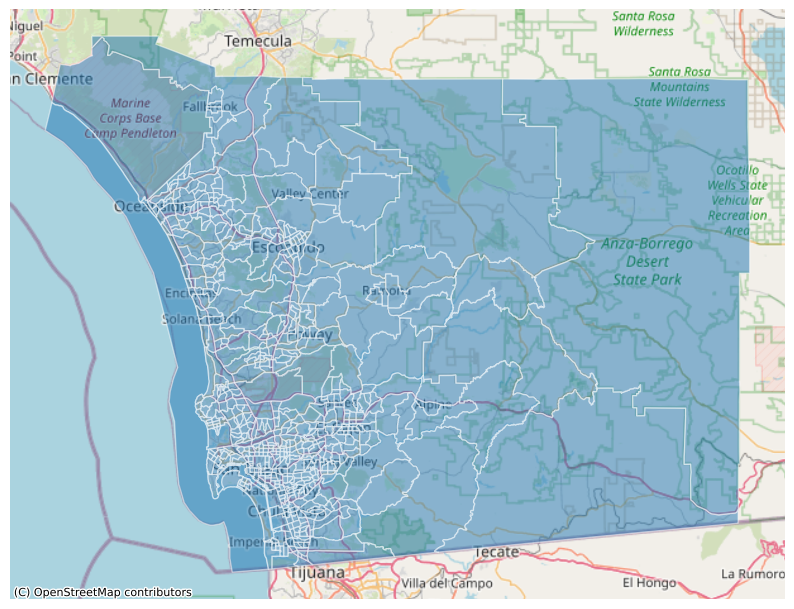

In [7]:
#visualization
f, ax = plt.subplots(1, figsize=(10, 10))
sandiego.plot(ax=ax, alpha=0.5, edgecolor='white')
cx.add_basemap(ax=ax, crs=sandiego.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.show()

Now that my dataset is ready and I have a good understanding of what I am working with, I can continue and finally start with the task

**1. Select two variables from the dataset**

The two variables I chose from the dataset for the spatial analysis are the following :

-  median_age = the median/average age

- total_pop  = total amount of population

I find both of the variables very interesting in spatially examining the city for the following tasks.
"median_age" provides me with interesting insights into the age distribution of San Diego's population.
And "total_pop" provides insights into the population composition of the city and therfore conveys better understanding of San Diego's patterns of density and demographic landscape.

**2. Explore the spatial distribution of those variables using choropleths. Comment on the
details of your maps and interpret the results**

I will now display the geographical distribution of the two variables using choropleths:

First, I display the "median_age" variable to explore its spatial distribution.

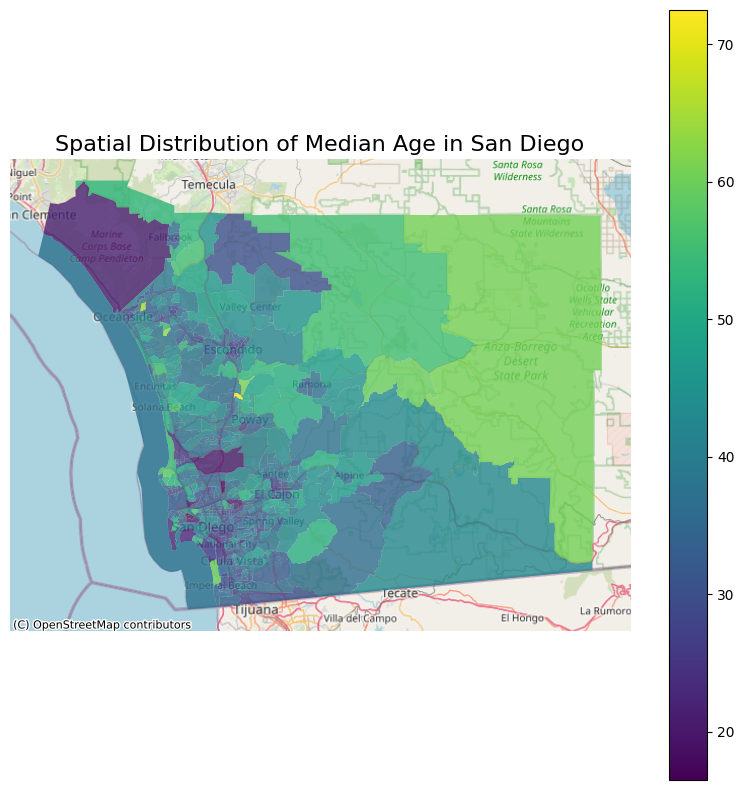

In [8]:
f, ax = plt.subplots(1, figsize=(10, 10))

sandiego.plot(
    column="median_age", 
    legend=True,
    ax=ax,
    alpha=0.8
)

# Set the title and axis labels
plt.title("Spatial Distribution of Median Age in San Diego", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

cx.add_basemap(ax=ax, crs=sandiego.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.show()

In the plot the lighter/more yellow/green shades represent higher values of the "median_age" and therefore indicate the areas where the median age is relatively higher compared to areas with lighter shades and therefore that the average age is higher.
And vice versa, the darker/more purple shades represent lower values of the "median_age" and therefore indicate areas with a lower median age.


The values for the highest median age (yellow) highest values can be found in about three small districts, middle-northern areas near oceanside and on the highway between Poway and Escondido. These values are not spread uniformly but are rather concentrated in these three specific smaller regions.
This suggests that these specific districts have a relatively older population compared to other areas, possibly due to factors such as elderly care facilities or retirement communities.

The values for the next high median age (light green) can be found in areas like the oceanside of Chula Vista and Imperial Beach, the oceanside to the south of Solana Beach, in the Anza Borrego Desert State Park, near the highway between Escondido and Poway. The factors contributing to higher median ages here include a proximity to the ocean and areas in and around a lot of nature where more old people tend to prefer to settle down.

The values for the third highest median age (green) can be found in the areas north-western part of the Anza Borrego Desert State Park, in the most northern part above the Marine Base Camp (around the area of Deluz), in the area between Escondida and Ramona, in the southern area around La Presa (eastern of Chula Vista) and around Solana Beach. The factors here that contribute to a higher median age are just like the ones, I described before: proximtiy to nature and ocean. However, in this variable range, the areas are nearer to cities, than the ones in the range before. This might suggest that while a slightly lower median age range still tends to locate near nature, it also wants closer proximity to urban areas.

The values of medium placed median age (blue) can be found in the south-eastern area around the Cleveland National Forest and the Anza Borrego Desert State Park and the whole coastal zone along the oceanside.
This suggests that a median age that is neither exceptionally high nor exceptionally low compared to the rest of San Diego, likes to locate in areas with proximity to nature, as well has reachability of cities

The values of the second lowest median age (light purple) can be found above Valley Center around the Palomar Mountain, along the Cleveland National Forest, the Cuyamaca Rancho State Park and the nature-areas in the south-west and in and around the cities that are located in the urban middle areas like Escondido, Poway, Oceanside, Spring Valley, Chula Viste etc. This suggests that younger people tend to distribute towards urban areas and cities. Which makes sense, because urban areas provide better working and education possibilities, as well as a lot of social communities and activities which attracts younger people.

The values of the lowest median age (dark purple) can be found in the Marine Corps Base Camp Pendleton, around the National City above Chula Vista, in the oceanside areas Point Loma and Coronado, in the city centre of San Diego, around Mira Mesa, Sorrento Valley and the University City area.
This distribution suggests that the reason for the youngest population compared to the rest of San Diego are factors like the presence of universities, military installations, and other factors that attract a younger demographic like proximity to the  central city.

In general I can see that the younger median age values tend to distribute more towards urban areas, and especially towards the areas in and around San Diego city. And the older median age values tend to distribute more towards the outside areas of the cities and more towards the nature areas, whether thats coastal area in the west or forest area in the east.

Next, I plot the "total_pop" variable

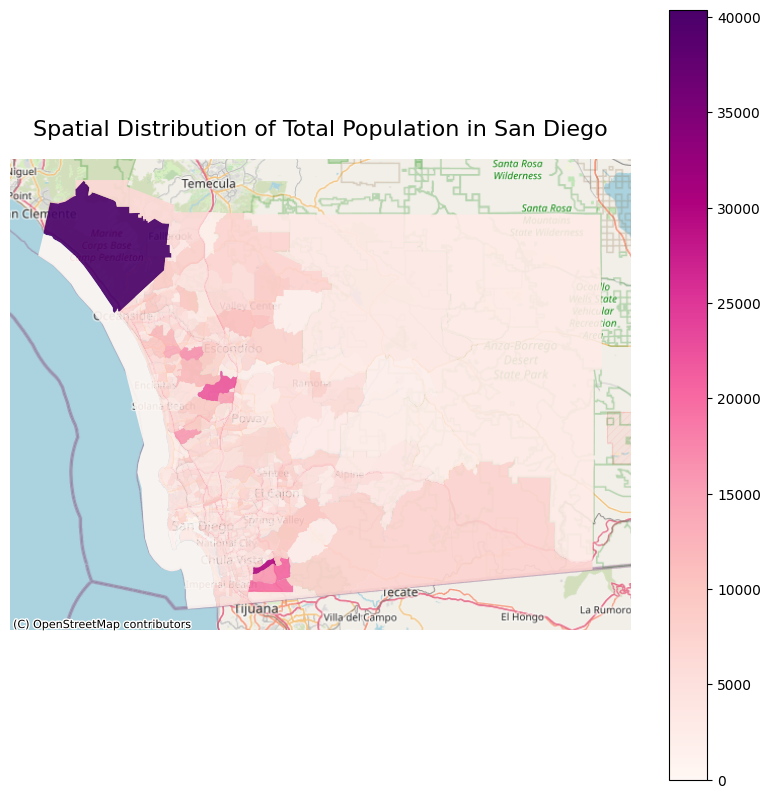

In [9]:
f, ax = plt.subplots(1, figsize=(10, 10))

sandiego.plot(
    column="total_pop", 
    cmap="RdPu",  
    legend=True,
    ax=ax,
    alpha=0.9
)

# Set the title and axis labels
plt.title("Spatial Distribution of Total Population in San Diego", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

cx.add_basemap(ax=ax, crs=sandiego.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.show()

In the plot the darker/purple shades represent higher values of the "total_pop" and therefore indicate the areas where the total population is relatively higher compared to areas with lighter shades and therefore that the population is higher.
And vice versa, the lighter/pink/nude shades represent lower values of the "total_pop" and therefore indicate areas with a lower total population.

I can see a distinct pattern in this choropleth map that most of the whole area is colored in light shade indicating that the majority of regions have relatively lower population counts. This can be explained that most of the area is nature-based (especially the eastern part) which indicates that not many people live in those areas. Higher population amounts tend to concentrate towards cities and urban region.

The values for the highest total population (dark purple) can be found in one single area, the Marine Corps Base Camp Pendleton.
This could be due to the factor of the presence of a military population and military facilities.

The values for the medium high total population (pink) can be found in the areas around Chula Vista and Imperial Beach south to San Diego city, and the areas located west of Escondido.

The values for slightly lower total population (light pink) can be found in most urban areas in the western part of the San Diego metropolitan area near the cities (especially Escondido), and also the big southern area of Anza Borrego Desert State Park.

The values for the lowest total population (light pastel pink/ nude) can be found in the complete Anza Borrego Desert State Park area, the immediate coastal area and the nature area underneath Spring Valley.

In general, I can see that the highest amount of population is located in the military camp. There is a general tendency for higher population values to distribute near the urban areas which are located in the western half of the map. Lower population values can be found in more eastern areas, where the presence of nature is predominant. This makes sense, because in general there are more living, housing and working possibilites in urban areas, which explains the trend for people in San Diego to live predominantly in and around the urban areas.

**3. Explore the degree of spatial autocorrelation (both global and local) of those variables.
Describe the concepts behind your approach and interpret your results**

I first need to get my dataset ready,in order to do a spatial autocorrelation

To do a spatial autocorrelation, I need to create a spatial weights matrix first.
When creating a spatial weights matrix, I need to think of a criterium to build it on that I think would fit my variables.


For "median_age" and "total_pop" I consider using contiguity-based weights or distance-based weights, depending on the spatial relationships I believe are relevant for the analysis.

For both of them I chose contiguity-based weights.
I expect that median age patterns and total population patterns are more likely to be similar in neighboring regions.
Therefore I am using a contiguity-based weights matrix for both variables, because the spatial relationships influencing the "median_age" and "total_pop variable are defined by proximity.

For both variables I chose the Queen criterium. The Queen criterion is relatively inclusive compared to other contiguity criteria, because areas are considered neighbors if they share a common border or vertex. This inclusiveness is particularly relevant for demographic variables like "median_age" and "total_pop" that may not follow very strict geographic boundaries.

So, I create a spatial weights matrix using the Queen criterium for my "sandiego" dataset that I can use for both of my variables

In [10]:
w = weights.Queen.from_dataframe(sandiego, ids="GEOID")

With my new matrix, I take one geometry as an example to get insights into the spatial relationships of that geometry by displaying its neighbors according to the Queen criterium

In [11]:
example_geometry_id = '06073018300'
w[example_geometry_id]

{'06073018200': 1.0,
 '06073018601': 1.0,
 '06073018100': 1.0,
 '06073018400': 1.0,
 '06073990100': 1.0,
 '06073018700': 1.0}

I need to make sure my geography does not have islands, because spatial autocorrelation techniques assume that the geometry is contiguous. A disconnected island would mess up this assumption.

Therefore, I check if my geometry has islands. If yes, it prints me out the islands and then I will remove them. If no, it will tell me accordingly

In [12]:
if len(w.islands)==0:
    print("The dataset has no islands")
else:
    print(f"The following geometries are islands: {w.islands}")

The dataset has no islands


The printout says "no islands", therefore I have to do nothing else and can move on

Next, I row-standardise my spatial weights matrix to ensure that each entity contributes equally to the overall measure of spatial autocorrelation, regardless of the number of neighbors it has

In [13]:
w.transform = 'R' # row-standardize

Now, I check the example geometry again, after the row-standardization

In [14]:
w[example_geometry_id]

{'06073018200': 0.16666666666666666,
 '06073018601': 0.16666666666666666,
 '06073018100': 0.16666666666666666,
 '06073018400': 0.16666666666666666,
 '06073990100': 0.16666666666666666,
 '06073018700': 0.16666666666666666}

Now that I have my matrix ready, I will start with the "median_age" variable.
For the "median_age" variable I start with the global spatial autocorrelation

To do that, I first create the standardised version of the "median_age" score.
I create a new column in "sandiego" called "age_stdze" and put calculated values into it that represent the standardized scores  for the 'median_age' variable

In [15]:
sandiego['age_stdze'] = (sandiego['median_age'] - sandiego['median_age'].mean()) / sandiego['median_age'].std()

I now check on my standardized version of the "median_age" score with two print statements and visually with a Kernel Density Estimation plot.

The two print statements provide me information about the mean and standard deviation of the standardized variable.
They round the 'age_stdze' variable to one decimal and print the mean (=mu) and standard (=sigma) deviation.
To see if it the "age_stdze" is well standardized, the "mu" should be near 0 and the "sigma" should be near 1 (approx. a N(0,1) distribution).

Then, I plot the distribution of "age_stdze" visually with the KDE plot. It should look like a bell curve to indicate that the values are distributed normally.

As can be seen after the code lines, both the print statements and the plot deliver me the wanted results

mu = 0.0
sigma = 1.0


<Axes: xlabel='age_stdze', ylabel='Density'>

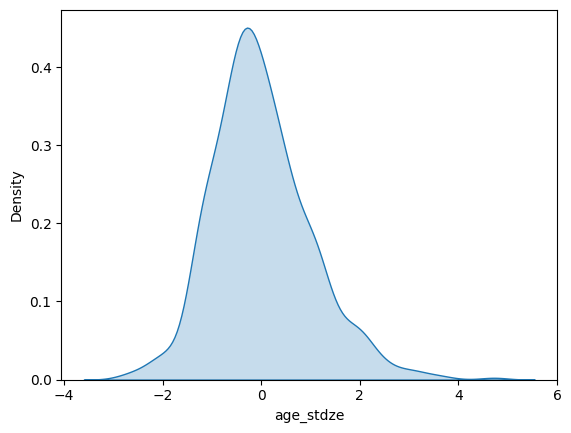

In [16]:
print(f"mu = {round(sandiego['age_stdze'].mean(), 1)}")
print(f"sigma = {round(sandiego['age_stdze'].std(), 1)}")

sns.kdeplot(sandiego['age_stdze'], fill=True)

Now, I create the spatial lag of the "age_stdze" variable using the spatial weights matrix and save it in a new column "w_age_stdze" in the sandiego dataset.
After that the spatial lag values are in the new column and represent the average standardized age value in its neighboring areas weighted by the spatial relationships

In [17]:
sandiego['w_age_stdze'] = weights.lag_spatial(w, sandiego["age_stdze"])

I now check if the new "w_age_stdze" is computed correctly with the example geometry by using the "weights.lag_spatial function".
The calculated spatial lag for the example geometry is saved in a new variable "w_age_example_geometry_pysal".

I also compute the spatial lag for the same example geometry manually to then compare it to the one in "w_age_example_geometry_pysal".
The manual calculation identifies the neighbors of the example geometry with the matrix, gets their standardized age values, calculates the mean of it and then stores the result in the new variable "w_age_example_geometry_manual".

Then I print both of these seperately computed spatial lag values to compare them.

In [18]:
# checking if the "w_age_stdze" is computed correctly with the example geometry

# the "w_age_stdze" for the example geometry using weights.lag_sapatial() function (pysal library)
w_age_example_geometry_pysal = sandiego.loc[sandiego['GEOID'] == example_geometry_id, ['w_age_stdze']].values[0][0]

# the "w_age_stdze" for the example geometry computed "manually"
w_age_example_geometry_manual = sandiego.loc[sandiego['GEOID'].isin(w.neighbors[example_geometry_id]), ['age_stdze']].mean()[0]

print(f"pysal: {w_age_example_geometry_pysal}")
print(f"manual: {w_age_example_geometry_manual}")

pysal: -0.3916858994169004
manual: -0.3916858994169004


As I can see with the result, both spatial lag values are the same, which tells me that the pysal calculation worked well

Now that my data is ready and prepared, I can finally start with the spatial autocorrelation. I will start with the **global** spatial autocorrelation for the "median_age" variable :


I start by calculating the Moran's I with its p-value for "median_age".
The Moran's I is a statistic for the global spatial autocorrelation, because it provides a measure of the strength and direction of spatial autocorrelation and therefore shows whether and how similar values are spatially clustered or dispersed.

For that I create "mi" in which I store the Moran object created by the "esda.Moran" method with my variable and my spatial weights matrix as input.

I then print out the Moran's I which shows me the measure of spatial autocorrelation of my "median_age" variable.
It can range from -1 to 1. A value close to 1 suggests a positive spatial autocorrelation and therefore indicates similar values tend to be close to each other.

And I print out the p-value of the Moran's I which indicates the statistical significance of the spatial autocorrelation. It should be a small number to indicate that the spatial pattern is not random

In [19]:
mi = esda.Moran(sandiego['median_age'], w)

print(f"Moran's I: {mi.I}")
print(f"Moran's I (p_value): {mi.p_sim}")

Moran's I: 0.3814404698927497
Moran's I (p_value): 0.001


I can see my Moran's I is moderately close to 1 (closer to 1 than to 0) and therefore indicates a moderate level of positive spatial autocorrelation. This tells me that areas with similar values of "median_age" are somewhat clustered in space

The p-value is very small and therefore suggests that the spatial autocorrelation is very unlikely a result of random chance.

These two results indicate to me that there is a statistically significant and moderately positive spatial autocorrelation in 'median_age'. Therefore I can tell that areas with similar median ages tend to be spatially clustered, indicating a spatial pattern in the distribution of median ages across San Diego

I will now calculate the Moran's I again, this time with the standardized variable "age_stdze".
This does not impact the spatial autocorrelation measure itself, as Moran's I will be the same with the non-standardized variable.

This is only done for visualization purposes to bring the variables onto a common scale which makes it easier to compare and interpret spatial patterns in the visual plot 

In [20]:
mi_stdze = esda.Moran(sandiego['age_stdze'], w)

print(f"Moran's I : {mi_stdze.I}")
print(f"Moran's I (p_value): {mi_stdze.p_sim}")

Moran's I : 0.3814404698927496
Moran's I (p_value): 0.001


Now I can plot my Moran Scatterplot to visualize my "median_age" variable.
I do that with the "moran_scatterplot" function and my Moran's I as input.
The result delivers me a visualization plot to analyize the global spatial autocorrelation of my variable

(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Moran Scatterplot (0.38)'}, xlabel='Attribute', ylabel='Spatial Lag'>)

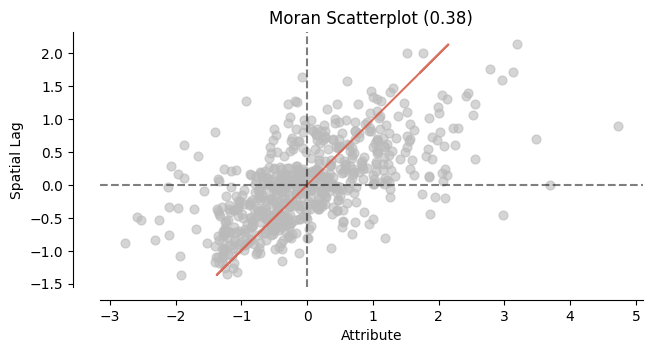

In [21]:
moran_scatterplot(mi)

Now I can visually see the spatial distribution of "median_age" against its spatial lag. 
Each point in the scatterplot represents a geographic area.

I can see a pattern of some dense clustering of points in the middle and in the lower left quadrant.
The clustering of points gets more loose and less dense when looking towards the upper right quadrant.
This pattern indicates to me that areas with low values tend to be clustered together, areas with moderate values are more dispersed, and areas with high values are less consistently clustered. 
As the Moran's I (0.38) value already suggested that there is some moderate positive spatial autocorrelation, it is also visible in a pattern in the Moran Scatterplot, because a clustering of points in a scatterplot suggests positive spatial autocorrelation.
The red line goes moderately upwards, which also suggests a moderate positive spatial autocorrelation pattern.
This moderate degree of positive spatial autocorrelation is more particular for low values and more inconsistent for high values.
This tells me that in a global context, neighboring areas in San Diego tend to have a similiar median age. And this effect tends to be stronger in lower median age areas than in higher median age areas, meaning that areas with lower median ages are more likely to be surrounded by neighboring areas with similar lower median ages.
This concludes that there is a pattern of neighboring areas to have similar median ages, with a stronger effect in lower median age areas and a weaker effect in higher median age areas.

Now, I will do the **local** spatial autocorrelation for the "median_age" variable :

I start with the initiation of the local spatial autocorrelation by calculating LISA statistics for the areas.
I do this by creating the variable "lisa" and with the "esda.Moran_Local" method I turn "lisa" into a moran local with the "median_age" variable and the matrix as input.

"lisa" is then able to identify local clusters of high or low values that are needed to explore local patterns of spatial autocorrelation

In [22]:
lisa = esda.Moran_Local(sandiego['median_age'], w)

Now, I am making a map that visualizes the local spatial autocorrelation results for the "median_age" variable in San Diego.

For that I need define a significance level "p", that classifies clusters as significant or not based on the specified level.
I chose a significance level of 5%, because it is a good standard and commonly used level, as it provides balance between specificity and sensitivity when classifying clusters as significant

(<Figure size 640x480 with 1 Axes>, <Axes: >)

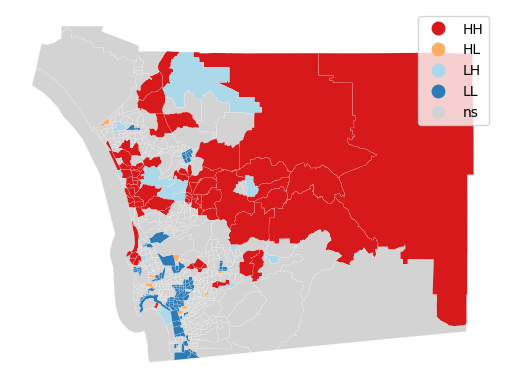

In [23]:
lisa_cluster(lisa, sandiego, p=0.05)

The map now visually provides me the 5 clusters. The fifth cluster contains the "ns" not-significant clusters, meaning those that are above the 5% significance level

For the analysis and interpretation, I will compute the numbers of LSOAS for each cluster.

In [24]:
# getting the quadrant and significance from "lisa" object
sandiego['significant'] = lisa.p_sim < 0.05
sandiego['quadrant'] = lisa.q

# getting the label for each LSOAS using a mapping from the quadrant number to the label
lisa_mapping = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'}
sandiego['lisa_quadrant_label'] = sandiego['quadrant'].apply(lambda x: lisa_mapping[x])

# setting the label "ns" to all the not significant quadrants
sandiego['lisa_quadrant_label'] = np.where(sandiego['significant'], sandiego['lisa_quadrant_label'], 'ns')

# counting how many LSOAS are for each label
print(sandiego['lisa_quadrant_label'].value_counts())

# printing out
sandiego[['GEOID', 'median_age', 'quadrant', 'significant', 'lisa_quadrant_label']].head()

lisa_quadrant_label
ns    429
LL    102
HH     73
LH     16
HL      8
Name: count, dtype: int64


GEOID  median_age  quadrant  significant lisa_quadrant_label
0  06073018300        37.1         3        False                  ns
1  06073018601        41.2         4         True                  HL
2  06073017601        54.4         1         True                  HH
3  06073019301        42.3         1        False                  ns
4  06073018700        21.8         2        False                  ns


- Hotspots: high values surrounded by high values (HH) : 72 (colored in red)
- Coldspots: low values nearby other low values (LL) : 100 (colored in blue)
- Outliers (Diamonds):high values among low values (HL) : 7 (colored in orange)
- Outliers (Donuts): low values among high values (LH) : 16 (colored in babyblue)
- non-significant (ns) : 433 (colored in grey)




With that at hand, I can identify 72 hotspots (red areas in the LISA map) located in most of the nature areas in the east, the Anza Borrego State park area, areas in the north next the Military base, coastal urban areas in and around cities like Encintas and Solana Beach and nature areas around the Ramona Grasslands City Preserve. These hotspots indicate the areas that have high median age and are surrounded by areas with a high median age.

I can identify 100 coldspots (blue areas) located in most urban areas in and around San Diego city and urban areas like Vista and Escondido. They indicate the areas that have a low median age and are surrounded by areas with low median age.

This confirms my results from the global spatial autocorrelation which indicated a moderate positive spatial autocorrelation that was particularly strong for low median age numbers. This goes hand in hand with the coldspots with an amount of 100 being the highest number in the map. The hotspots are also quite a lot, but less than the coldspots.

There are also two spatial outliers.
I can identify 7 Diamonds (HL, colored in orange) located in the urban areas around San Diego city and one underneath the military base. They indicate the areas that have a high median age and are surrounded by areas with a low median age.
And I can identify 16 Donuts (LH, colored in babyblue) located in northern nature based areas, in urban areas in and around Escondido, some areas to the east of the Anza Borrego Park and urban areas in and around San Diego city. They indicate the areas that have a low median age and are surrounded by areas with a high median age.
The outliers have values that are significantly different from their neighboring areas.

The spatial outliers together counting 23 also confirm my global spatial autocorrelation results. In comparision to the cold- and hotspots (172 together) they are a way smaller number and therefore indicate a positive spatial autocorrelation.

Now, I will do the **global** spatial autocorrelation for the **"total_pop"** variable :

I explained prior to creating the spatial weights matrix that I will use the Queen criterium for "total_pop" aswell. Therefore I can use my already created matrix "w" for this variable again.

For the global spatial autocorrelation for "total_pop" I have to go through the same steps, that I did for "median_age". Therefore I will not document the single steps as precisely as I did for "median_age", because they are the same just with the new variable

I start again by preparing my data.

To do that, I first create the standardised version of the "total_pop" score.
I create a new column in "sandiego" called "pop_stdze" and put calculated values into it that represent the standardized scores  for the 'total_pop' variable

In [25]:
sandiego['pop_stdze'] = (sandiego['total_pop'] - sandiego['total_pop'].mean()) / sandiego['total_pop'].std()

I now check on my standardized version of the "total_pop" score with two print statements and visually with a Kernel Density Estimation plot.

The two print statements provide me information about the mean and standard deviation of the standardized variable.
They round the 'pop_stdze' variable to one decimal and print the mean (=mu) and standard (=sigma) deviation.
To see if it the "pop_stdze" is well standardized, the "mu" should be near 0 and the "sigma" should be near 1 (approx. a N(0,1) distribution).

Then, I plot the distribution of "pop_stdze" visually with the KDE plot. It should look like a bell curve to indicate that the values are distributed normally.

As can be seen after the code lines, both the print statements and the plot deliver me the wanted results

mu = 0.0
sigma = 1.0


<Axes: xlabel='pop_stdze', ylabel='Density'>

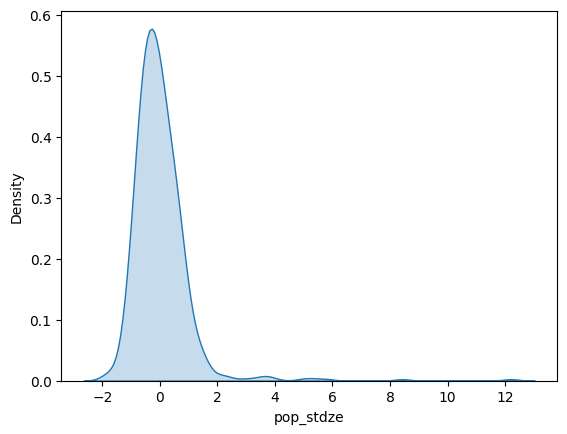

In [26]:
print(f"mu = {round(sandiego['pop_stdze'].mean(), 1)}")
print(f"sigma = {round(sandiego['pop_stdze'].std(), 1)}")

sns.kdeplot(sandiego['pop_stdze'], fill=True)

Now, I create the spatial lag of the "pop_stdze" variable using the spatial weights matrix and save it in a new column "w_pop_stdze" in the sandiego dataset.

After that the spatial lag values are in the new column and represent the average standardized population value in its neighboring areas weighted by the spatial relationships

In [27]:
sandiego['w_pop_stdze'] = weights.lag_spatial(w, sandiego["pop_stdze"])

I now check if the new "w_pop_stdze" is computed correctly with the example geometry by using the "weights.lag_spatial function".
The calculated spatial lag for the example geometry is saved in a new variable "w_pop_example_geometry_pysal".

I also compute the spatial lag for the same example geometry manually to then compare it to the one in "w_pop_example_geometry_pysal".
The manual calculation identifies the neighbors of the example geometry with the matrix, gets their standardized population values, calculates the mean of it and then stores the result in the new variable "w_pop_example_geometry_manual".

Then I print both of these seperately computed spatial lag values to compare them.

In [28]:
# checking if the "w_pop_stdze" is computed correctly with the example geometry

# the "w_pop_stdze" for the example geometry using weights.lag_sapatial() function (pysal library)
w_pop_example_geometry_pysal = sandiego.loc[sandiego['GEOID'] == example_geometry_id, ['w_pop_stdze']].values[0][0]

# the "w_pop_stdze" for the example geometry computed "manually
w_pop_example_geometry_manual = sandiego.loc[sandiego['GEOID'].isin(w.neighbors[example_geometry_id]), ['pop_stdze']].mean()[0]

print(f"pysal: {w_pop_example_geometry_pysal}")
print(f"manual: {w_pop_example_geometry_manual}")

pysal: 1.8071221354086273
manual: 1.8071221354086273


As I can see with the result, both spatial lag values are the same, which tells me that the pysal calculation worked well

Now that my data is ready and prepared, I can finally start with the global spatial autocorrelation for the "total_pop" variable :

I start by calculating the Moran's I with its p-value for "total_pop".

For that I create "mi2" in which I store the Moran object created by the "esda.Moran" method with my variable and my spatial weights matrix as input.

I then print out the Moran's I which shows me the measure of spatial autocorrelation of my "total_pop" variable.
It can range from -1 to 1. A value close to 1 suggests a positive spatial autocorrelation and therefore indicates similar values tend to be close to each other.

And I print out the p-value of the Moran's I which indicates the statistical significance of the spatial autocorrelation. It should be a small number to indicate that the spatial pattern is not random

In [29]:
mi2 = esda.Moran(sandiego['total_pop'], w)

print(f"Moran's I: {mi2.I}")
print(f"Moran's I (p_value): {mi2.p_sim}")

Moran's I: 0.1527048969698898
Moran's I (p_value): 0.001


I can see my Moran's I is higher than 0 and therefore indicates positive spatial autocorrelation. However this number is not very close to 1 (it is closer to 0 than to 1), this tells me that the level of positive spatial autocorrelation is not very strong.
Therefore areas with similar total population values are somewhat clustered in San Diego, but that clustering pattern is not strong.

The p-value is very small and therefore suggests that the spatial autocorrelation is very unlikely a result of random chance.

These two results indicate to me that there is a statistically significant and weak positive spatial autocorrelation in 'total_pop'. Therefore I can tell that areas with similar total population tend to be slightly spatially clustered, contributing to a subtle spatial pattern in the distribution of total population across San Diego.
The spatial clustering of areas with similar total population values in San Diego is present but not highly pronounced.

I will now calculate the Moran's I again, this time with the standardized variable "pop_stdze".
This does not impact the spatial autocorrelation measure itself, as Moran's I will be the same with the non-standardized variable.

This is only done for visualization purposes to bring the variables onto a common scale which makes it easier to compare and interpret spatial patterns in the visual plot 

In [30]:
mi_stdze2 = esda.Moran(sandiego['pop_stdze'], w)

print(f"Moran's I : {mi_stdze2.I}")
print(f"Moran's I (p_value): {mi_stdze2.p_sim}")

Moran's I : 0.15270489696988976
Moran's I (p_value): 0.001


Now I can plot my Moran Scatterplot to visualize my "total_pop" variable.
I do that with the "moran_scatterplot" function and my Moran's I as input.
The result delivers me a visualization plot to analyize the global spatial autocorrelation of my variable

(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Moran Scatterplot (0.15)'}, xlabel='Attribute', ylabel='Spatial Lag'>)

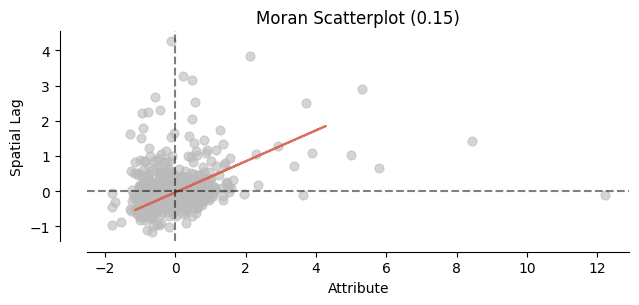

In [31]:
moran_scatterplot(mi2)

Now I can visually see the spatial distribution of "total_pop" against its spatial lag. 
Each point in the scatterplot represents a geographic area.

The red line is going updwards in a moderate manner which indicates to me a positive spatial autocorrelation. This aligns with the positive Moran's I value (0.153) that I calculated earlier.
I can see a big and dense clustering of points in the middle of the scatterplot, this clustering gets a little bit more loose when looking towards the upper right quadrant.
As the Moran's I (0.153) value already suggested that there is some weak positive spatial autocorrelation, it is also visible in a pattern in the Moran Scatterplot, because a clustering of points in a scatterplot suggests positive spatial autocorrelation.

This tells me that in a global context, the neighboring areas in San Diego have a slight tendency to have similar total population values. The big and dense cluster in the middle of the scatterplot signifies a concentration of areas with similar total population sizes, and this clustering becomes somewhat more loose towards the upper right quadrant.
This tells me that the clustering is more pronounced in areas with similar populations.

Now, I will do the **local** spatial autocorrelation for the "total_pop" variable :

I start with the initiation of the local spatial autocorrelation by calculating LISA statistics for the areas.
I do this by creating the variable "lisa2" and with the "esda.Moran_Local" method I turn "lisa2" into a moran local with the "total_pop" variable and the matrix as input.

"lisa2" is then able to identify local clusters of high or low values that are needed to explore local patterns of spatial autocorrelation

In [32]:
lisa2 = esda.Moran_Local(sandiego['total_pop'], w)

Now, I am making a map that visualizes the local spatial autocorrelation results for the "total_pop" variable in San Diego.

For that I need to define a significance level "p", that classifies clusters as significant or not based on the specified level.
I chose a significance level of 5%, because it is a good standard and commonly used level, as it provides balance between specificity and sensitivity when classifying clusters as significant

(<Figure size 640x480 with 1 Axes>, <Axes: >)

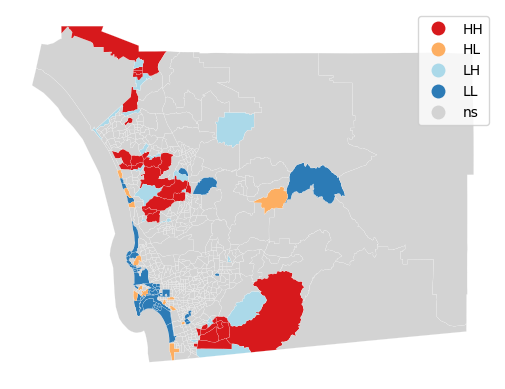

In [33]:
lisa_cluster(lisa2, sandiego, p=0.05)

The map now visually provides me the 5 clusters. The fifth cluster contains the "ns" not-significant clusters, meaning those that are above the 5% significance level

For the analysis and interpretation, I will compute the numbers of LSOAS for each cluster

In [34]:
# getting the quadrant and significance from "lisa" object
sandiego['significant2'] = lisa2.p_sim < 0.05
sandiego['quadrant2'] = lisa2.q

# getting the label for each LSOAS using a mapping from the quadrant number to the label
lisa_mapping2 = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'}
sandiego['lisa_quadrant_label2'] = sandiego['quadrant2'].apply(lambda x: lisa_mapping2[x])

# setting the label "ns" to all the not significant quadrants
sandiego['lisa_quadrant_label2'] = np.where(sandiego['significant2'], sandiego['lisa_quadrant_label2'], 'ns')

# counting how many LSOAS are for each label
print(sandiego['lisa_quadrant_label2'].value_counts())

# printing out
sandiego[['GEOID', 'total_pop', 'quadrant2', 'significant2', 'lisa_quadrant_label2']].head()

lisa_quadrant_label2
ns    518
LL     45
HH     31
LH     21
HL     13
Name: count, dtype: int64


GEOID  total_pop  quadrant2  significant2 lisa_quadrant_label2
0  06073018300     2590.0          2          True                   LH
1  06073018601     5147.0          2          True                   LH
2  06073017601     5595.0          1         False                   ns
3  06073019301     7026.0          1          True                   HH
4  06073018700    40402.0          4         False                   ns


Hotspots: high values surrounded by high values (HH) : 27 (colored in red)
Coldspots: low values nearby other low values (LL) : 43 (colored in blue)
Outliers (Diamonds):high values among low values (HL) : 14 (colored in orange)
Outliers (Donuts): low values among high values (LH) : 19 (colored in babyblue)
non-significant (ns) : 525 (colored in grey)

With that at hand, I can identify 27 hotspots (red areas in the LISA map) located in the most northern area above the military camp, urban areas in and around Lake San Marcos and southern areas around the Otay Open Space Preserve. These hotspots indicate the areas that have high total population and are surrounded by areas with a high total population.

I can identify 43 coldspots (blue areas) located in the urban areas in and around San Diego city and the more nature based areas around Poway. They indicate the areas that have a low total population and are surrounded by areas with low total population.

This confirms my results from the global spatial autocorrelation which indicated a slight positive spatial autocorrelation that was slightlsy stronger for low total population numbers. This goes hand in hand with the coldspots with an amount of 43 being the highest number in the map. However this amount of coldspots is not extremely high compared to the other numbers.

There are also two spatial outliers.
I can identify 14 Diamonds (HL, colored in orange) located in and around urban areas, specifically in coastal cities. They indicate the areas that have a high total population and are surrounded by areas with a low total population.
And I can identify 19 Donuts (LH, colored in babyblue) located in the northern urban areas, the areas around the military base and in the south-eastern urban areas. They indicate the areas that have a low total population and are surrounded by areas with a high total population.
The outliers have values that are significantly different from their neighboring areas.

The spatial outliers together counting 33 (14 Diamonds + 19 Donuts) also confirm my global spatial autocorrelation results. In comparison to the cold- and hotspots counting 70 (27 Hotspots + 43 coldspots) they are a smaller number and therefore indicate a positive spatial autocorrelation. The difference between these numbers is for example not as big as it was for "median_age", this also confirms that the positive spatial autocorellation is more weak (0.153).

## Part II — Toronto Flickr: Visualising Activity & Detecting Hotspots

**Goal:** Move from demographics to *behavioral* signals by mapping where people actually gather and creating **Areas of Interest (AOIs)** from crowd-sourced photo locations.

**Methods**

- Tackled over-plotting with **hexbins** to reveal density structure before clustering.
- Applied **DBSCAN** to the geotagged points to (a) identify dense clusters as AOIs and (b) treat noise explicitly—an advantage over centroid-only methods.

**What I found (high level)**

- Clean AOIs align with well-known public spaces and corridors; sparse residential areas are correctly marked as noise—evidence the method isolates *true* activity hotspots rather than map artifacts.

**Outputs:** Point map, hexbin density view, and AOI cluster layer ready for web mapping.

****Part II - Common****

For this part i will be using the "Flickr photographs sample" dataset, it is a subsample of the 100 million Yahoo dataset that contains the location of photographs contributed to the Flickr service by its users for the city Toronto

**1. Visualize the dataset appropriately and discuss why you have taken your specific
approach**

Before I start with the visualization, I read my file and save it into "photos". I also print out an overview and general information of the dataset to see exactly what I am working with

In [35]:
#reading the file
photos = pd.read_csv("https://darribas.org/gds_course/_downloads/fc771c3b1b9e0ee00e875bb2d293adcd/toronto_flickr_subset.csv")
photos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    2000 non-null   int64  
 1   user_id               2000 non-null   object 
 2   user_nickname         2000 non-null   object 
 3   date_taken            2000 non-null   object 
 4   date_uploaded         2000 non-null   int64  
 5   title                 1932 non-null   object 
 6   longitude             2000 non-null   float64
 7   latitude              2000 non-null   float64
 8   accuracy_coordinates  2000 non-null   float64
 9   page_url              2000 non-null   object 
 10  video_url             2000 non-null   object 
dtypes: float64(3), int64(2), object(6)
memory usage: 172.0+ KB


This information overview shows me all 11 columns, their names, their count of non-null values (to check if there are any missing values) and their datatypes

The next line of code prints the datatype of "photos". The output shows me that "photos" is a dataframe

In [36]:
print(type(photos))

<class 'pandas.core.frame.DataFrame'>


The following line of code helps me to quickly grasp the size and structure of my "photos" dataset by returning the number of rows and the number of columns in the dataframe. The result shows me "photos" has 2000 rows and 11 columns

In [37]:
print(photos.shape)

(2000, 11)


Now, I print out the first 5 rows of the dataframe to provide me a quick preview and overall sense of the dataset's content

In [38]:
photos.head()

id       user_id        user_nickname           date_taken  \
0  30117279  73843395@N00                d0ndy  2013-07-16 21:51:25   
1  90380739   7616875@N04       daniel_dimarco  2006-03-29 20:50:24   
2  88392665  45631234@N04  taken+from+room+202  2010-01-19 15:47:04   
3  74572106  27291676@N06          photoswebpm  2010-06-23 11:46:09   
4  88825834  47442454@N02       Victor+Lewicki  2011-04-27 08:43:01   

   date_uploaded                                              title  \
0     1374025885                       Ron+Burgundy%21+%23Anchorman   
1     1185693030                                FOD06_0760_filtered   
2     1264272789                                           DSC_0182   
3     1277394369  Le+PM+assiste+%C3%A0+la+c%C3%A9r%C3%A9monie+de...   
4     1303964676                                                NaN   

   longitude   latitude  accuracy_coordinates  \
0 -79.380426  43.656074                  16.0   
1 -79.394674  43.663447                  14.0   
2 -79.426989  43.642667                  15.0   
3 -79.413363  43.635267                  15.0   
4 -79.434000  43.822167                  16.0   

                                            page_url  \
0  http://www.flickr.com/photos/73843395@N00/9305...   
1  http://www.flickr.com/photos/7616875@N04/93595...   
2  http://www.flickr.com/photos/45631234@N04/4298...   
3  http://www.flickr.com/photos/27291676@N06/4730...   
4  http://www.flickr.com/photos/47442454@N02/5662...   

                                           video_url  
0  http://farm8.staticflickr.com/7443/9305361840_...  
1  http://farm2.staticflickr.com/1341/935958785_9...  
2  http://farm3.staticflickr.com/2738/4298401740_...  
3  http://farm2.staticflickr.com/1344/4730009951_...  
4  http://farm6.staticflickr.com/5185/5662997355_...

Now that I checked all the data and important information of my dataset, I can start to prepare my dataset in order to appropriately visualize it

Some lines before, I checked with "print(type(photos))" that the datatype of "photos" is a dataframe.
But because "photos" is only a dataframe and not a geodataframe (it does not have a geometry column), I have to turn "photos" into a geodataframe. 

In the next steps I will use the two columns "longitude" and "latitude" and put them into the following method. 
This method transforms my dataframe "photos" into a geodataframe that I will call "ph".

After executing this line of code, I can use the "ph" geodataframe to take advantage of the geopandas visualization feature that is needed for the task

In [39]:
ph = gpd.GeoDataFrame(photos, geometry=gpd.points_from_xy(photos['longitude'], photos['latitude']))

I now have a geometry column in "ph" that contains point geometries representing the locations of the photos based on the provided longitude and latitude columns in the original "photos" dataframe

But because of the use of the "latitude" and "longitude" columns, I have to use an ESPG of"4326" as CRS which represents latitude and longitude on the Earth's surface. This provides proper mapping and analysis of the data in real-world coordinates.

So with the following method I will set the CRS for the "ph" to the needed ESPG

In [40]:
ph = ph.set_crs('epsg:4326')

Now, I check again to make sure "ph" is a finally a geodataframe and my code before worked out. And the result shows me exactly that

In [41]:
print(type(ph))

<class 'geopandas.geodataframe.GeoDataFrame'>


For "ph" I also take a look at the size of the dataset. It shows me that "ph" has 2000 rows and now 12 columns. 
Because I added a geometry column to "ph" it makes sense that it has one more column than "photos"

In [42]:
print(ph.shape)

(2000, 12)


And again, I also print out an overview and general information of the "ph" to see exactly what I am working with. And I can also see my new geometry column

In [43]:
ph.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   id                    2000 non-null   int64   
 1   user_id               2000 non-null   object  
 2   user_nickname         2000 non-null   object  
 3   date_taken            2000 non-null   object  
 4   date_uploaded         2000 non-null   int64   
 5   title                 1932 non-null   object  
 6   longitude             2000 non-null   float64 
 7   latitude              2000 non-null   float64 
 8   accuracy_coordinates  2000 non-null   float64 
 9   page_url              2000 non-null   object  
 10  video_url             2000 non-null   object  
 11  geometry              2000 non-null   geometry
dtypes: float64(3), geometry(1), int64(2), object(6)
memory usage: 187.6+ KB


I again print out the first 5 rows of the dataframe to provide me a quick preview and overall sense of the dataset's content. This also shows me my new geometry column and its content and therefore assures me that it contains point geometries

In [44]:
ph.head()

id       user_id        user_nickname           date_taken  \
0  30117279  73843395@N00                d0ndy  2013-07-16 21:51:25   
1  90380739   7616875@N04       daniel_dimarco  2006-03-29 20:50:24   
2  88392665  45631234@N04  taken+from+room+202  2010-01-19 15:47:04   
3  74572106  27291676@N06          photoswebpm  2010-06-23 11:46:09   
4  88825834  47442454@N02       Victor+Lewicki  2011-04-27 08:43:01   

   date_uploaded                                              title  \
0     1374025885                       Ron+Burgundy%21+%23Anchorman   
1     1185693030                                FOD06_0760_filtered   
2     1264272789                                           DSC_0182   
3     1277394369  Le+PM+assiste+%C3%A0+la+c%C3%A9r%C3%A9monie+de...   
4     1303964676                                                NaN   

   longitude   latitude  accuracy_coordinates  \
0 -79.380426  43.656074                  16.0   
1 -79.394674  43.663447                  14.0   
2 -79.426989  43.642667                  15.0   
3 -79.413363  43.635267                  15.0   
4 -79.434000  43.822167                  16.0   

                                            page_url  \
0  http://www.flickr.com/photos/73843395@N00/9305...   
1  http://www.flickr.com/photos/7616875@N04/93595...   
2  http://www.flickr.com/photos/45631234@N04/4298...   
3  http://www.flickr.com/photos/27291676@N06/4730...   
4  http://www.flickr.com/photos/47442454@N02/5662...   

                                           video_url  \
0  http://farm8.staticflickr.com/7443/9305361840_...   
1  http://farm2.staticflickr.com/1341/935958785_9...   
2  http://farm3.staticflickr.com/2738/4298401740_...   
3  http://farm2.staticflickr.com/1344/4730009951_...   
4  http://farm6.staticflickr.com/5185/5662997355_...   

                     geometry  
0  POINT (-79.38043 43.65607)  
1  POINT (-79.39467 43.66345)  
2  POINT (-79.42699 43.64267)  
3  POINT (-79.41336 43.63527)  
4  POINT (-79.43400 43.82217)

Now, that I have all my data ready, I can finally start with my visualization process to find the most appropriate one.

To solve this, I will go through some visualizations of the dataset, check their advantages and disadvantages and in the end chose the best visualization.

Visualization nr.1 : with this one i will be showing patterns as dots on a basemap.
This visualization I do is rather simple and easy, but it gives me a good overview of the whole city and the dataset.

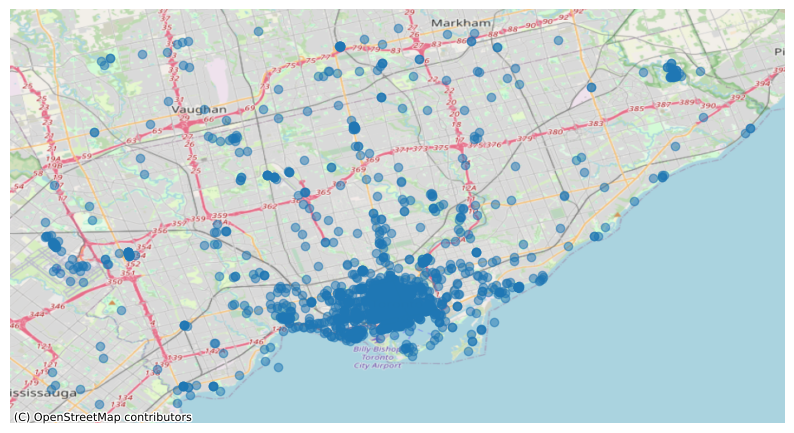

In [45]:
#visualization nr1
f, ax = plt.subplots(1, figsize=(10, 10))
ph.plot(ax=ax, alpha=0.5)
cx.add_basemap(ax=ax, crs=ph.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.show()

The advantages I found with this visualization method are, that it is quite simple, straighforward and gives a good overview of the city and the points. It shows me that the dots tend to be concentrated in the center of the city in a pattern, as well as some localized clusters of points outside of the center.

However, I can clearly see that there are overplotting issues with many points being concentrated in specific areas, where the density of points is so large that it is hard to tell anything indivdual. These overlapping points make it challenging to discern individual points and their true density.

All in all, this visualization works well for initial exploration and providing a spatial context. However, for a more clear analysis and clearer visualization especially concerning the point density, a better visualization is necessary

Visualization Nr.2 : Showing density with aggregation through hexbinning (Hex binning map of the property locations)

A solution to get around the cluttering is to generate a grid (in this case a hexagonal) and count how many dots fall within each grid cell. This helps to overcome the overplotting issue

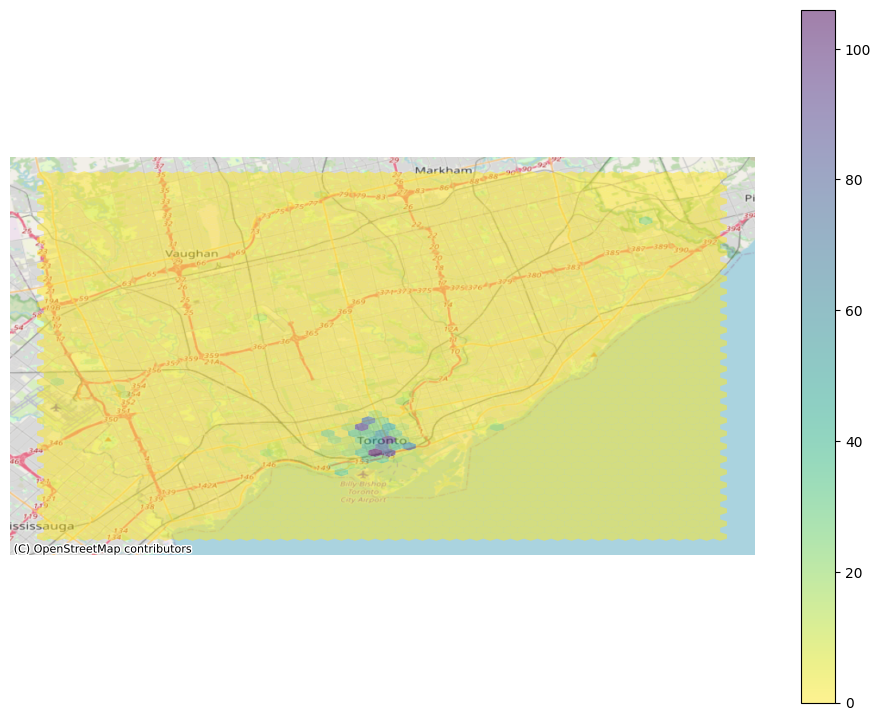

In [46]:
#Hex binning map
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))

# Generate and add hexbin
hb = ax.hexbin(
    ph["longitude"],
    ph["latitude"],
    gridsize=50,
    linewidths=0,
    alpha=0.5,
    cmap="viridis_r",
)

# Add basemap
cx.add_basemap(ax, crs=ph.crs, source=cx.providers.OpenStreetMap.Mapnik)

plt.colorbar(hb)
ax.set_axis_off()
plt.show()

As I can see in the visualization, the Hex binning provides a way to visualize the density of points in a nice continuous manner. This makes it much easier to identify high- and low-density areas. By aggregating the points within the hexagonal bins, the overplotting is reduced, especially in the areas with a high concentration of points like the city center.


While the Hex Binning is already quite appropriate and nicely displays the content of the dataset, I know of a potentially better and visually more smooth visualization. This leads me to try out a third and last visualization in my next step

Visualization Nr.3 : kernel density estimate (KDE) of the distribution of the photographs

This visualization results in a smoother output that captures the same thing as the Hex Binning, but with much smoother transitions between different areas and better highlighted clusters.
Because of that, I will now also try the KDE visualization in order to see if it gives me a better visualization of the photos in the city than the Hex binning

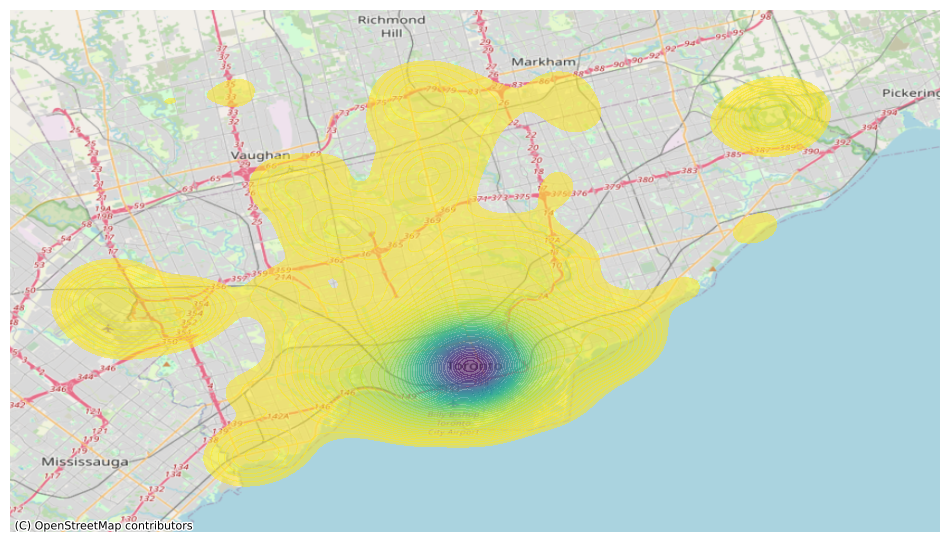

In [47]:
#kernel density estimate (KDE)

# Setting up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))

sns.kdeplot(
    x="longitude",
    y="latitude",
    data=ph,
    n_levels=50,
    fill=True,
    alpha=0.55,
    cmap="viridis_r",
    ax=ax
)

# Adding a basemap
cx.add_basemap(ax, crs=ph.crs, source=cx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.show()

Now seeing the visualization of the KDE, I choose this visualization (Nr.3) as the appropriate and best visualization of the dataset. 
The advantages of the KDE to visualization Nr.1 are almost the same as those of the Hex Binning. The KDE helps in avoiding issues related to overplotting.
Also the smooth contours in the KDE plot provide a cleaner and more readable representation of the spatial distribution compared to the Hex Binning. I like this especially in contrast to the blocky and less continuous surface of the Hex Binning visualization, which gave me a less smooth representation of the density.

With the KDE, I can clearly see the flow of point density of the photos, changing from very dense in the Toronto centre to less dense going further outward with some scattered less dense spots in certain areas.
I can easily decipher that the high density and therefore high amount of picutres taken are in the immediate center of the city (colored in purple). Then the further you go outside of the city center it is clearly visible that the density and therefore the amount of pictures taken changes from a medium amount (colored in blue) to less amount (colored in yellow). I will explain my observations a bit better covering each colour on the map :

The colour Purple covers the immediate city center, meaning most pictures are being taken there. This makes sense, as there are many tourist sights like the famous CN Tower, that is almost always present in most pictures of Toronto. In this area is also the Central Waterfront which indicates a nice scenery for picture-taking. Most skyscrapers are in the city center (especially the Financial District) which is usually a very well liked motive. In general city centers tend to be tourist magnets where most people want to take pictures in.

The colour Turquoise follows the purple pattern immediately which indicates that the second highest amount of pictures are being taken in the immediate neighboring area to the city center.
This includes the coastal area and also the airport. It makes sense that a high amount of pictures are taken at this airport, because it directly faces the skyscraper skyline of the city. The outside area of the city center also provides a good amount of museums and the Botanical Garden which indicates the high amount of picture taking aswell.

The colour Yellow follows the turquoise pattern and builds the last pattern. This starts when leaving the center of the city and its close area. This pattern covers the rest of the Toronto city, all of its coastal area and also spreads out in areas that are more situated away from the city (towards Vaughan, Richmond Hill, Markham and Missauga). It also covers some random patterns that might indicate some special areas and/or tourist sights. In the west there is a random pattern around the Toronto Pearson International Airport. This makes sense, because a lot of people tend to make photos at airports when they first step into a new city/country. There is also a yellow spot in the most eastern part of the map. This spot covers the Toronto Zoo which might be the reason for the amount of pictures taken there. The yellow spot on the coastal area towards the east is the Guildwood Beach view, a popular spot for taking pictures.
The small spot over Vaughan covers the amusement park "Canada's Wonderland" which explains the high amount of taken pictures.

**2. Use DBSCAN to identify areas of the city with a high density of points, which we will call
areas of interest (AOI). In completing this, answer at least the following questions:**

- What parameters have you used to run DBSCAN? Why?
- What do the clusters help you learn about areas of interest in the city?
- Name one example of how these AOIs can be useful for the city. You can take the perspective of an urban planner, a policy maker, an operational practitioner (e.g.police, trash collection), an urban entrepreneur, or any other role you envision

For this task I need to have the DBSCAN method to use its algorithm. So to begin, I import the method from the library "scikit-learn"

In [48]:
from sklearn.cluster import DBSCAN

For this task I have to work with distances and because the data is expressed in longitude and latitude, I am converting the data into metric CRS so that it is expressed in metres and therefore I can work with distances in metres. I use the EPSG "4326" that refers to the "World Geodetic System 1984", used in GPS.

In the next step, I create a new geodataframe called "pts" in order to handle the change of the CRS separately from the "ph" dataset. This step assures me that my "ph" dataframe stays unchanged and in its original state during the setting of the crs.

So in the following code line, I use a method that takes the "longitude" and "latitude" and converts them into point geometries. It also sets the CRS to the ESPG:4326.
This prepares the data for the clustering with DBSCAN by making sure that the point geometries are associated with the correct CRS.

In [49]:
# expressing points in metres
# converting lon/lat into Point objects + set CRS
pts = gpd.points_from_xy(
    ph["longitude"],
    ph["latitude"],
    crs="EPSG:4326"
)

Now I create the new geodataframe "pts" by loading the point geometries from the code above into the new "geometry" column
and transform the CRS to the specific EPSG of Toronto.

To find the EPSG for Toronto in order to set my CRS accordingly, I use the website "epsg.io" and search for the EPSG of Toronto. As a result I found for "Canada - Ontario - Toronto" the EPSG:4536. 
And therefore in the following step I will set my CRS to ESPG:4536 and also extract the coordinates from the point objects into columns.

In [50]:
# converting lon/lat points to Toronto CRS in metres
pts = gpd.GeoDataFrame({"geometry": pts}).to_crs(epsg=4536)

I create 2 new columns for the x coordinate and y coordinate values in my original "ph" dataframe by extracting the x coordinate and y coordinate values from each point geometry in the "geometry" column of "pts" and storing them in meters in the new columns.

In [51]:
# Extracting coordinates from point objects into columns
ph["X_metres"] = pts.geometry.x
ph["Y_metres"] = pts.geometry.y

Now, I check my dataset "ph" to see if I successfully added my 2 new columns. 
And as can be seen, everything worked just fine.

In [52]:
ph.head()

id       user_id        user_nickname           date_taken  \
0  30117279  73843395@N00                d0ndy  2013-07-16 21:51:25   
1  90380739   7616875@N04       daniel_dimarco  2006-03-29 20:50:24   
2  88392665  45631234@N04  taken+from+room+202  2010-01-19 15:47:04   
3  74572106  27291676@N06          photoswebpm  2010-06-23 11:46:09   
4  88825834  47442454@N02       Victor+Lewicki  2011-04-27 08:43:01   

   date_uploaded                                              title  \
0     1374025885                       Ron+Burgundy%21+%23Anchorman   
1     1185693030                                FOD06_0760_filtered   
2     1264272789                                           DSC_0182   
3     1277394369  Le+PM+assiste+%C3%A0+la+c%C3%A9r%C3%A9monie+de...   
4     1303964676                                                NaN   

   longitude   latitude  accuracy_coordinates  \
0 -79.380426  43.656074                  16.0   
1 -79.394674  43.663447                  14.0   
2 -79.426989  43.642667                  15.0   
3 -79.413363  43.635267                  15.0   
4 -79.434000  43.822167                  16.0   

                                            page_url  \
0  http://www.flickr.com/photos/73843395@N00/9305...   
1  http://www.flickr.com/photos/7616875@N04/93595...   
2  http://www.flickr.com/photos/45631234@N04/4298...   
3  http://www.flickr.com/photos/27291676@N06/4730...   
4  http://www.flickr.com/photos/47442454@N02/5662...   

                                           video_url  \
0  http://farm8.staticflickr.com/7443/9305361840_...   
1  http://farm2.staticflickr.com/1341/935958785_9...   
2  http://farm3.staticflickr.com/2738/4298401740_...   
3  http://farm2.staticflickr.com/1344/4730009951_...   
4  http://farm6.staticflickr.com/5185/5662997355_...   

                     geometry      X_metres      Y_metres  
0  POINT (-79.38043 43.65607) -1.083632e+06  1.497730e+07  
1  POINT (-79.39467 43.66345) -1.082280e+06  1.497677e+07  
2  POINT (-79.42699 43.64267) -1.080238e+06  1.497972e+07  
3  POINT (-79.41336 43.63527) -1.081541e+06  1.498027e+07  
4  POINT (-79.43400 43.82217) -1.074766e+06  1.495989e+07

Now that my dataset is finally ready, I can initialize the DBSCAN clustering to set up the algorithm. Here I also need to set my "eps" and my "min_samples", I chose an eps of "1000" and a min_samples of "15".

Why I chose those parameters, I will explain by answering the question of this task *after* the visualization at the end.
Therefore I will just set them now and move on to the next steps of the DBSCAN.

In [53]:
# initializing DBSCAN clustering & setting up the algorithm
# eps = maximum distance for neighborhood points.
# min_samples =  minimum number of samples for a core point.
algo = DBSCAN(eps=1000, min_samples=15)

Now, I fit the clustering algorithm to the data on the columns "X_metres" and "Y_metres".
After it is fit, "algo" contains the required information to access all the results of the algorithm that will analyze the spatial distribution of points in the specified columns

In [54]:
algo.fit(ph[["X_metres", "Y_metres"]])

DBSCAN(eps=1000, min_samples=15)

Now I check the "core_sample_indices_" attribute that contains the indices of each data point that is classified as a core by the clustering algorithm. By choosing the first 5 of those core samples, I can check in a small range which points are being considered part of the dense regions. This is not a necessary step for the actual DBSCAN but rather a help for better understanding.

In [55]:
# Print the first 5 elements of `cs`
algo.core_sample_indices_[:5]

array([0, 1, 2, 3, 5])

Next I check the first 100 cluster labels of the points that are assigned by the algorithm. 
As a result, I can see the numbers that represent the cluster to which each point belongs.
I can also see the noise points with the number "-1" which do not belong to any cluster as they do not fall into the specified density criteria.
Again this is not necessary for the DBSCAN execution, but it helps me get a better understanding and information on the data.

In [56]:
algo.labels_[:100]

array([ 0,  0,  0,  0, -1,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0, -1, -1, -1,  0,  0,  0])

I can now start with the visualization process of the clusters

The labels that I checked out before, I will now add into a new column "cluster_label" to the "ph" dataframe. This column then contains the cluster label of each data point that were assigned by the clustering algorithm.
This new column will be used further down at the visualization step.

In [57]:
# adding labels as new columns
ph['cluster_label'] = pd.Series(algo.labels_, index=ph.index)

I now want to see by numbers how the data points are distributed across the clusters and also check for the amount of noise points.
Therefore I count the values of the "cluster_label" column which then returns the cluster labels and the count of data points assigned to each of the cluster

In [58]:
# counting points assigned to each cluster
ph['cluster_label'].value_counts()

cluster_label
 0    1499
-1     375
 3      37
 1      32
 4      23
 2      19
 5      15
Name: count, dtype: int64

There are 6 clusters. The seventh cluster "-1" represents the noice points which counts 375 data points as noise points.
The cluster "0" counts 1499 data points which is by far the highest amount of data points in a cluster.
The cluster "3" counts 37 data points which is the second highest amount (however huge difference to cluster 0).
The cluster "1" counts 32 data points, third highest amount.
The cluster "4" counts 23 data points, fourth highest amount.
The cluster "2" counts 19 data points, fifth highest amount.
And cluster "5" counts 15 data points which is the lowest amount of data points.

Now, I can do the actual visualization step with the following code block:

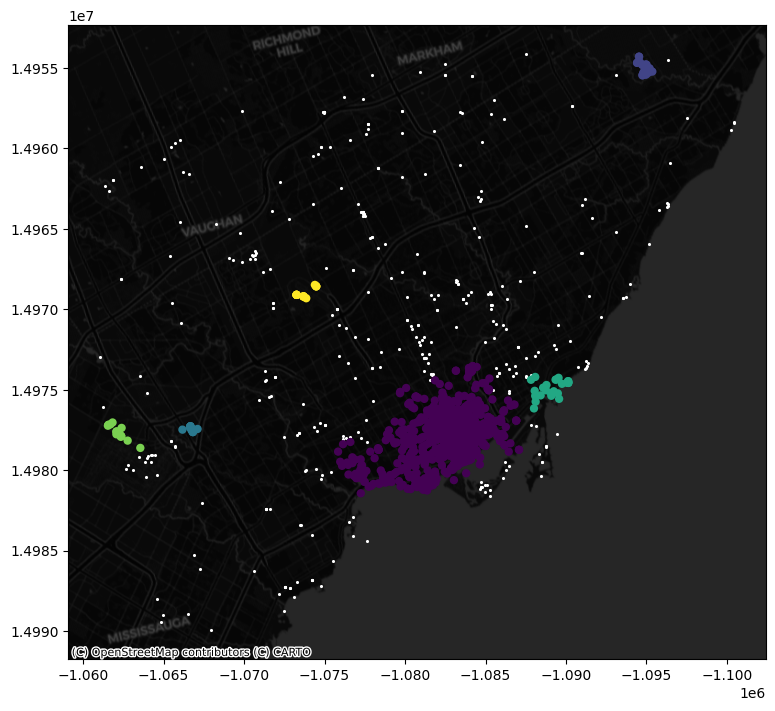

In [59]:
# Setting up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Creating a subset of the dataframe to split noise and cluster points
noise_points = ph.loc[ph['cluster_label']==-1]
cluster_points = ph.loc[ph['cluster_label']!=-1]

# Plotting the noise in white
ax.scatter(noise_points["X_metres"], noise_points["Y_metres"], c='white', s=5, linewidth=0)

# Plotting the cluster points with a different color for each cluster
ax.scatter(cluster_points["X_metres"], cluster_points["Y_metres"], c=cluster_points["cluster_label"], linewidth=0)

# Adding a basemap
cx.add_basemap(ax=ax, crs=ph.to_crs(epsg=4536).crs, source=cx.providers.CartoDB.DarkMatter)

# Inverting the y-axis and x-axis to prevent an upside-down and mirrored map
ax.invert_yaxis()
ax.invert_xaxis()

# Displaying the figure
plt.show()

Now with the visualization at hand, I will answer the following questions:


*What parameters have you used to run DBSCAN? Why?*

I tried out a couple of parameters by tweaking higher or lower eps and higher or lower min_samples. This lead me to a couple different combinations resulting in different visualizations.

With the numbers between 500 and 1000, I was able to find an appropriate range for the eps. Because I am dealing with the geography of a city, I quickly eliminated too high numbers (such as over 100.000). Then by trying out differently high and low numbers (ranging from 10.000 to 100), I was able to spot the most appropriate range. While too low numbers made the clusters way too detailed to discover any significant cluster pattern, too high numbers made the clusters almost non-identifiable and imprecise.
By trying out the parameters accordingly, I then found a great maximum distance for neighborhood points with eps=1000.

With the numbers between 5 and 20, I was able to find an appropriate range for the min_samples. I needed to make sure to find a good number that displayed the clusters neither too precise nor too imprecise. I eliminated the numbers that were too high (such as 50 and above) by realizing that they made the clusters coarse, imprecise and at certain heights they only showed one cluster. On the other hand, numbers that were too low (anything under 5) displayed so many clusters and showed such a high level of detail that it was almost counterproductive, over detailed and impossible to discover significant patterns.
Neither too low, nor too high numbers gave me the ability to discover any relevant patterns through the displayed clusters. Again by tweaking the numbers in the appropriate range, I found a great minimum number of samples for a core point with min_samples=15. This moderate parameter ensured me that the clusters are not too sensitive to noise but still capture meaningful density.

During the search of these parameters, I also made sure to adjust the parameters together in the given ranges and compare the visualization results. I found the best visualization was with the eps of 1000 and the min_samples of 15. The selected parameters let me discern clusters with an interesting pattern.
The displayed clusters were neither too detailed, nor too imprecise. I was able to discover meaningful and significant patterns at a nice and appropriate detail level.

*What do the clusters help you learn about areas of interest in the city?*

I discovered a pattern of 6 clusters, which gave me some interesting clues about Toronto.

Cluster 0 is colored in purple in the map and covers by far the most points. It covers the immediate city center, meaning most pictures are being taken there. This suggests that this might be an especially touristy and popular area. 
These clues make sense, as it covers the city center where many tourist sights are, like the famous CN Tower, that is almost always present in most pictures of Toronto. In this area is also the Central Waterfront which indicates a nice scenery for picture-taking. Most skyscrapers are in the city center (especially the Financial District) which is usually a very well liked motive.

Next to the big purple Cluster 0 is the Cluster 3 colored in turquiose, which covers a coastal area near the east of the city center. This suggest that this might also be a popular area or an area with a nice scenery.
In this area is the Woodbine Beach Westdock located, a sight which is very popular for picture taking as it faces the skyline of Toronto. This confirms my clues that I got from this cluster.

In the most western part of the city is the small Cluster 1, colored in green points. This indicates to me that there might also be a popular spot where a lot of people might be present. And the results of the map show me that this cluster covers the Toronto Pearson International Airport. This makes sense, because a lot of people tend to make photos at airports, when they first see the city.

Next to the green Cluster, is the blue Cluster 5 which covers a small amount of points. This might also be a small spot, where either a lot of people cummulate or a popular tourist attraction lays. This cluster covers the Toronto Congress Centre which confirms my guess, because a lot of different especially foreign business people cummulate at such a spot. This indicates the fact that a lot of pictures are being taken there.

The small Cluster 4 with purple-blue points is located in a small spot in the north-east of the city. Again this suggests that this might a place where a lot of people merge together. The results show me that this cluster covers the Toronto Zoo and the Rouge National Urban Park. Zoos and National Parks are well known picture attractions, which explains the existence of the cluster.

Near Vaughan is Cluster 2 with some yellow points. The amount of points suggests that this might also be a popular spot, either touristy, or again a lot of people cummulate at this certain spot. The map results show that this cluster covers an area that is filled with fun and sporting activities for tourists and locals like an Escape Room, the National Beach Volleyball Training Centre, the Chesswood Arena for ice-hockey. Because there will most likely be held important Volleyball or Ice-hockey games a lot of people visit and take pictures.

*Name one example of how these AOIs can be useful for the city. You can take the
perspective of an urban planner, a policy maker, an operational practitioner (e.g.
police, trash collection), an urban entrepreneur, or any other role you envision*

As an example I take the operational practitioners that can benefit from AOIs to optimize their operations.

The Police for example are able to allocate resources more efficiently by focusing on areas with higher activity or potential security concerns. High density places indicate a certain popularity of these places and therefore have larger masses of people in them. Large masses of people usually indicate an increased criminality and security issue such as pick-pocketing and stealing (in especially touristy areas), any sort of illegal businesses (selling things illegally and without license on street markets or offering illegal services like e.g. shoe cleaning) or terrorist attacks.
AOIs with high photo density indicate areas of increased human activity and potentially areas with a higher risk of certain types of crimes.
Law enforcement can use these AOIs to identify crime hotspots, guiding the allocation of patrols and resources to enhance public safety.
As an example I can take Germany concerning their bigger cities, in which after increasing terrorist attacks over the years, the amount of paroling and stationed police has significantly increased. The policemen look strategically for AOIs and dense areas to station their men there, because these areas are at much higher risk of being victim to a terrorist attack than less dense areas (because in the point of view of a terrorist, dense areas mean more victims).
The Police can positively utilize AOIs in predictive policing strategies and law enforcement can anticipate potential incidents based on historical patterns.
These AOIs are very helpful for the police, because they help the police to act way more strategic and prepared and therefore ensure much more safety for the population.

****Part III - Choose your own adventure****

For this part, you need to pick one of the following two options. Using the datasets from A, pick
only one task, and make the most of it.

**1. Create a clustering and interpret the results. In the process, answer at least the following
questions:**
- What are the main types of clusters you identify?
- Which characteristics help you delineate this typology?
- If you had to use this segmentation to target areas in most need, how would you
use it? why?

**2. Create a regionalisation and interpret the results. In the process, answer at least the
following questions:**
- How is the city partitioned by your data?
- What do you learn about the geography of the city from the regionalisation?
- What would one useful application of this regionalization in the context of urban
policy?

For this part I am chosing to do the 2nd task and create the regionalisation for the Toronto dataset.

To begin, I am reading the file of Toronto and saving the dataset into the variable "toronto".

In [60]:
#reading the file
toronto = gpd.read_file("https://darribas.org/gds_course/_downloads/a2bdb4c2a088e602c3bd6490ab1d26fa/toronto_socio-economic.gpkg")

With the next line of code I display a quick and concise summary of the dataframe to provide me any useful information about  it, like number of entries and data type of each column

In [61]:
toronto.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   _id                   140 non-null    int64   
 1   AREA_NAME             140 non-null    object  
 2   Shape__Area           140 non-null    float64 
 3   neighbourhood_name    140 non-null    object  
 4   population2016        140 non-null    float64 
 5   population_sqkm       140 non-null    float64 
 6   pop_0-14_yearsold     140 non-null    float64 
 7   pop_15-24_yearsold    140 non-null    float64 
 8   pop_25-54_yearsold    140 non-null    float64 
 9   pop_55-64_yearsold    140 non-null    float64 
 10  pop_65+_yearsold      140 non-null    float64 
 11  pop_85+_yearsold      140 non-null    float64 
 12  hh_median_income2015  140 non-null    float64 
 13  canadian_citizens     140 non-null    float64 
 14  deg_bachelor          140 non-null    float64 
 15

I print out the first 5 rows of my dataset to get a good overview of all the columns

In [62]:
toronto.head()

_id                     AREA_NAME   Shape__Area       neighbourhood_name  \
0  9101                 Wychwood (94)  3.217960e+06                 Wychwood   
1  9102          Yonge-Eglinton (100)  3.160334e+06           Yonge-Eglinton   
2  9103           Yonge-St.Clair (97)  2.222464e+06           Yonge-St.Clair   
3  9104  York University Heights (27)  2.541821e+07  York University Heights   
4  9105       Yorkdale-Glen Park (31)  1.156669e+07       Yorkdale-Glen Park   

   population2016  population_sqkm  pop_0-14_yearsold  pop_15-24_yearsold  \
0         14349.0           8541.0             1860.0              1320.0   
1         11817.0           7162.0             1800.0              1225.0   
2         12528.0          10708.0             1210.0               920.0   
3         27593.0           2086.0             4045.0              4750.0   
4         14804.0           2451.0             1960.0              1870.0   

   pop_25-54_yearsold  pop_55-64_yearsold  ...  deg_bachelor  deg_medics  \
0              6420.0              1595.0  ...        2770.0        80.0   
1              5860.0              1325.0  ...        3625.0       155.0   
2              5960.0              1540.0  ...        3720.0       225.0   
3             12290.0              2965.0  ...        3910.0       105.0   
4              5860.0              1810.0  ...        1595.0        60.0   

   deg_phd  employed  bedrooms_0  bedrooms_1  bedrooms_2  bedrooms_3  \
0    295.0    7470.0        60.0      1860.0      1420.0      1610.0   
1    330.0    6815.0       260.0      2045.0      1335.0      1085.0   
2    290.0    7245.0       270.0      3005.0      2320.0       815.0   
3    185.0   13235.0       145.0      2795.0      2765.0      2620.0   
4     95.0    6670.0        30.0       975.0      1300.0      1885.0   

   bedrooms_4+                                           geometry  
0        940.0  POLYGON ((-79.43592 43.68015, -79.43492 43.680...  
1        945.0  POLYGON ((-79.41096 43.70408, -79.40962 43.704...  
2        615.0  POLYGON ((-79.39119 43.68108, -79.39141 43.680...  
3       1850.0  POLYGON ((-79.50529 43.75987, -79.50488 43.759...  
4       1155.0  POLYGON ((-79.43969 43.70561, -79.44011 43.705...  

[5 rows x 24 columns]

In "variables_toronto" I save the variable list file that provides me with more useful information on each of the socio-economic variables. With that I can get a better overview of each variable in order to choose the most interesting ones for my regionalization process

In [63]:
#more information on each of the socio-economic variables in the variable list file:

variables_toronto = pd.read_csv("https://darribas.org/gds_course/_downloads/8944151f1b7df7b1f38b79b7a73eb2d0/toronto_socio-economic_vars.csv")

variables_toronto

_id                  name                     Category  \
0      3        population2016                   Population   
1      8       population_sqkm                   Population   
2     10     pop_0-14_yearsold                   Population   
3     11    pop_15-24_yearsold                   Population   
4     12    pop_25-54_yearsold                   Population   
5     13    pop_55-64_yearsold                   Population   
6     14      pop_65+_yearsold                   Population   
7     15      pop_85+_yearsold                   Population   
8   1018  hh_median_income2015                       Income   
9   1149     canadian_citizens  Immigration and citizenship   
10  1711          deg_bachelor                    Education   
11  1713            deg_medics                    Education   
12  1714               deg_phd                    Education   
13  1887              employed                       Labour   
14  1636            bedrooms_0                      Housing   
15  1637            bedrooms_1                      Housing   
16  1638            bedrooms_2                      Housing   
17  1639            bedrooms_3                      Housing   
18  1641           bedrooms_4+                      Housing   

                                     Topic                     Data Source  \
0                 Population and dwellings  Census Profile 98-316-X2016001   
1                 Population and dwellings  Census Profile 98-316-X2016001   
2                      Age characteristics  Census Profile 98-316-X2016001   
3                      Age characteristics  Census Profile 98-316-X2016001   
4                      Age characteristics  Census Profile 98-316-X2016001   
5                      Age characteristics  Census Profile 98-316-X2016001   
6                      Age characteristics  Census Profile 98-316-X2016001   
7                      Age characteristics  Census Profile 98-316-X2016001   
8             Income of households in 2015  Census Profile 98-316-X2016001   
9                              Citizenship  Census Profile 98-316-X2016001   
10  Highest certificate, diploma or degree  Census Profile 98-316-X2016001   
11  Highest certificate, diploma or degree  Census Profile 98-316-X2016001   
12  Highest certificate, diploma or degree  Census Profile 98-316-X2016001   
13                     Labour force status  Census Profile 98-316-X2016001   
14               Household characteristics  Census Profile 98-316-X2016001   
15               Household characteristics  Census Profile 98-316-X2016001   
16               Household characteristics  Census Profile 98-316-X2016001   
17               Household characteristics  Census Profile 98-316-X2016001   
18               Household characteristics  Census Profile 98-316-X2016001   

                                       Characteristic  
0                                    Population, 2016  
1             Population density per square kilometre  
2                               Children (0-14 years)  
3                                 Youth (15-24 years)  
4                           Working Age (25-54 years)  
5                        Pre-retirement (55-64 years)  
6                                 Seniors (65+ years)  
7                           Older Seniors (85+ years)  
8   Total - Income statistics in 2015 for private ...  
9                  Canadian citizens aged 18 and over  
10                                  Bachelor's degree  
11        Degree in medicine, dentistry, veterinar...  
12                                   Earned doctorate  
13                                           Employed  
14                                        No bedrooms  
15                                          1 bedroom  
16                                         2 bedrooms  
17                                         3 bedrooms  
18                                 4 or more bedrooms

I make a quick visualizations of my dataset to get a good overview of the city, its location and its structures with an additional basemap

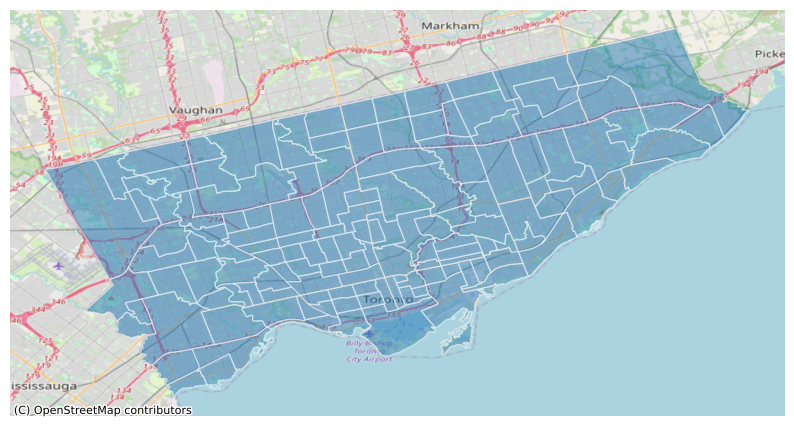

In [64]:
#visualization
f, ax = plt.subplots(1, figsize=(10, 10))
toronto.plot(ax=ax, alpha=0.5, edgecolor='white')
cx.add_basemap(ax=ax, crs=toronto.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.show()

Now, I import all the packages that I need for my regionalization. 

I am importing the cluster module from scikit-learn, this provides various clustering algorithms that can be used for tasks regarding the grouping of data points into clusters based on similarity.

I am also importing the MinMaxScaler class from scikit-learn, this provides a certain technique that I need to use for scaling numerical features to a specified range

In [65]:
from sklearn import cluster
from sklearn.preprocessing import MinMaxScaler

Now I have all the data ready to start my regionalization.

I begin with the creation of a spatial weights matrix for my regionalization process using a k-nearest neighbors (KNN) approach.

I chose the k-nearest neighbors as the spatial weights matrix for regionalization due to its consideration of spatial proximity between areas. This is particularly crucial in a regionalization process where the goal is to cluster neighboring areas with similar characteristics. The knn matrix assumes that areas in close proximity are more likely to exhibit similar features.
The incorporation of spatial relationships into the clustering process is important for regionalization, as it takes into account the spatial context when forming clusters. Additionally, the knn captures local relationships, meaning that each entity is influenced by its immediate neighbors. This is beneficial where local patterns and characteristics hold significance.

For the knn I am chosing a k-number of 5, as this number is a balanced and moderate amount of neighbours to capture meaningful spatial relationships. This number is perfectly balancing the need for capturing important spatial relationships while avoiding excessive sensitivity to local variations

In [183]:
wreg = weights.KNN.from_dataframe(toronto, k=5)

I now set my number of clusters for the regionalization. 
I chose to partition the city into 4 clusters, as this amount separates the city in a reasonable and moderate way in which distinct regional patterns are discernable. 4 clusters ensures that the clustering aligns with the inherent spatial characteristics of the data while still being appropriate to interpret.

In [67]:
n_clusters = 4

Now in the next three steps, I continue with normalizing the features.

First, I set up a MinMaxScaler to scale the features to a specified range to ensure that they are on a similar scale. 

In [68]:
scaler = MinMaxScaler()

Now I select my columns that I will use in the regionalization and put them into a variable called "x".

By choosing suitable variables for the regionalization I kept in mind that the goal is to identify clusters or groups of regions that share similar socio-economic and demographic characteristics.
Therefore I chose the following variables:

- employed (employment)
- population_sqkm (population density per square kilometre)
- hh_median_income2015 (total income)

Each of these variables provides insights into different aspects of the socio-economic and demographic landscape, and together, they offer a comprehensive view of the characteristics of different regions.
By combining these variables, I will be able to identify and characterize regions in Toronto based on their employment patterns, income level, and population distribution. It's a well rounded set of variables that can contribute to a meaningful regionalization analysis. 

In [69]:
X = toronto[['employed', 'hh_median_income2015', 'population_sqkm']]

Now I can scale my selected variables to ensure that they are on a similar scale

In [70]:
X = scaler.fit_transform(X)

In the next step I will use the "AgglomerativeClustering" algorithm to group the spatial areas of Toronto into 4 clusters based on their similarity or proximity. I save this step into the variable "sagg" which I then fit using my variables that are stored in "x".

After that, "sagg" contains the information about the clusters assigned to each data point in the variables based on the AgglomerativeClustering algorithm

In [184]:
sagg = cluster.AgglomerativeClustering(n_clusters=n_clusters, connectivity=wreg.sparse)
sagg.fit(X)

AgglomerativeClustering(connectivity=<140x140 sparse matrix of type '<class 'numpy.float64'>'
	with 700 stored elements in Compressed Sparse Row format>,
                        n_clusters=4)

Next, I assign the cluster labels obtained from the AgglomerativeClustering algorithm (sagg.labels_) to a new column named 'cluster_label' in the "toronto" geodataframe. 
"toronto" will now have a new column called 'cluster_label' that indicates the cluster to which each geographic entity in Toronto belongs, based on the Agglomerative Clustering results

In [185]:
# adding cluster label (result) to toronto
toronto['cluster_label'] = sagg.labels_

As a result, each row in "toronto" corresponds to a cluster label, and the columns represent the mean values of the specified features for each cluster. 
I now print the results in order to analyze and compare the average values of these features across the different clusters

In [186]:
# printing results
print(toronto['cluster_label'].value_counts().sort_index())
toronto.groupby('cluster_label')[['employed', 'hh_median_income2015', 'population_sqkm']].mean()

cluster_label
0    94
1    43
2     1
3     2
Name: count, dtype: int64


employed  hh_median_income2015  population_sqkm
cluster_label                                                     
0               9249.787234           7368.351064      4336.893617
1               9622.790698           8146.511628      9129.837209
2              48470.000000          40750.000000      8943.000000
3              14852.500000          14625.000000     33682.500000

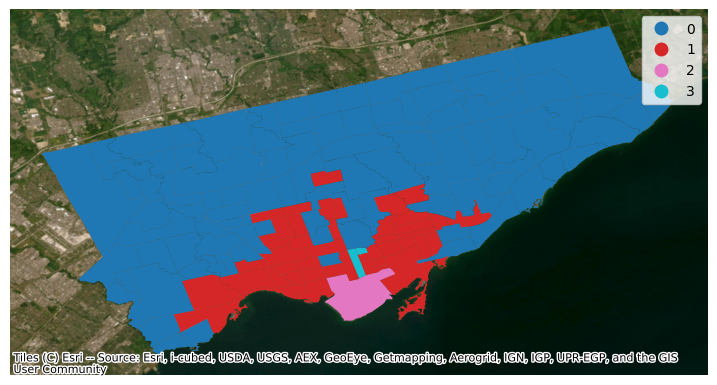

In [187]:
#visualization
f, ax = plt.subplots(1, figsize=(9, 9))
toronto.plot(ax=ax, column='cluster_label', categorical=True, legend=True, linewidth=0.5)
cx.add_basemap(ax=ax, crs=toronto.crs, source=cx.providers.Esri.WorldImagery)
ax.set_axis_off()
plt.show()

*How is the city partitioned by your data?*

My regionalization process for the three variables "employed", "population_sqkm" and "hh_median_income2015" has grouped Toronto into 4 distinct clusters.

The first cluster Cluster "0" is colored in blue in the visualization. It contains 94 areas, which indicates that the algorithm grouped these 94 areas together based on their similiarity in the variables. This cluster in general represents the areas with, in comparison to the other clusters, the lowest employment rates, the lowest median income and the lowest population density.

The Cluster "1" is colored in red and contains 43 areas. In general, in comparison to the other clusters, this cluster represents the areas with a low (second lowest, close to cluster 0) employment rate, a low (second lowest, close to cluster 0) median income and the a high (second highest) population density. While employment rate and median income are both low, these areas are relatively densly populated.

The Cluster "2" is colored in pink and contains 1 area. In general, this cluster represents the area with the highest employment rate, the highest median income and the second lowest population density. The employment rate and median income is compared to the other clusters the highest with a big difference. While these two variables are the highest in this area, it is not very densly populated.

The last cluster, Cluster "3" is colored in babyblue and contains 2 areas. In general, this cluster represents the areas with a high employment rate (second highest, however not on cluster 2's level), a high median income (second highest, however also not on cluster 2's level) and the highest population density. Compared to the other clusters, the employment rate and the median income are moderately high. Cluster 3's areas are the most densly populated.

*What do you learn about the geography of the city from the regionalisation?*

Each Cluster and the areas it covers based on the three variables gives me some interesting insights into the geography of Toronto. 

Cluster "0" covers the areas with the lowest employment rates, the lowest median income and the lowest population density. This gives me some clues on the location of these areas. Less densly populated areas are usually found in more outside of the center located areas, where the possibility to live in houses instead of apartments is given. Low employment can usually also be found more outside because there seems to be less Business areas and less possibilities to be employed at. A low median income can also be usually found in outside areas, because the housing is compared to the central areas much cheaper and affordable which attracts the people who have a lower income.
These clues can be perfectly seen in the visual map, where the blue cluster exclusively covers all the outside located areas of Toronto, like Markham and Richmond Hill. 

Cluster "1" cover the areas with a low employment rate, a low median income and relatively high population density. This gives me clues on the location of these areas. Densly populated areas are usually found in more central areas. Low employment can usually be found in more outside areas where less working possibilites are. Low income can also be found in more outside areas, where housing tends to be more affordable and attracts lower income households. These clues can be well seen in the visual map, where the red cluster covers the central eastern and western city outside of the immediate center. This cluster also spreads into more outside areas.

Cluster "2" pink covers the one area with the highest employment rate, the highest median income and the second lowest population density. High employment is usually found in more central areas because the working possibilites are higher and more. High median income is also usually found in central areas, where housing and living tends to be the most expensive, attracting the households that can afford that comfortably. Less dense population usually indicate more outside areas, however in this case it indicates to the immediate city center where the housing is more sparse, as it usually contains buildings for business and working. These clues can be well seen in the visual map, where the pink cluster only covers the immediate city center
which is located at the coastal side and includes the Financial District, a lot of Skyscrapers and the City Island with the Airport. The presence of the Airport might also indicate why this area is less dense.

Cluster 3 babyblue covers the two areas with a moderate high employment rate and median income, and the highest population density. A moderate high employment can be usually found in more central leaning areas which have a lot of working opportunities. A moderate high median income can also indicate central areas, where the expensive housing attracts high income households. A very high population density also indicates central areas, where apartments are the most common housing.
These clues can be well seen in the visual map, where the babyblue cluster covers two very central areas. It covers the northern Downtown area of Toronto which the main business district which explains the high employment. The area seems to follow the Yonge street which is the retail core of downtown and also covers the area of the  University of Toronto which explains the very high population density.

*What would one useful application of this regionalization in the context of urban
policy be?*

The results of the regionalization can help in the urban development of Toronto. Policymakers can use the insights of the clusters to help overcome any disparities between the clusters to enforce a more balanced development of all areas of the city. This can help overcome the median income and employment differences of the clusters. The results for example showed that central areas tend to have both higher median income and higher employment rates than those areas outside of the center. By creating more and better working conditions in the outside areas, more people could reach an employment status and find work. This would also positively influence the median income. This can be done by locating more and more businesses and industries in the outside areas.
Cluster 3 showed results of the highest population density with more median high employment and income. Policymakers could improve this condition with urban development by for example improving the public transportation infrastructure. This can be helpful for all cluster areas, especially those with lower employment. Policymakers can strategically improve the public transportation of the lower employment clusters to help them reach higher employment areas.

**Part IV - Going beyond!**
Apply a method that was not provided in the lecture and lab materials of the course. You can use
whatever dataset (from A or B) that is interesting to you. If you lack ideas, here are some suggestions you
could use for this part:
- Provide some analyses where you spatially join a new data set
- Fit a spatial regression model (and potentially perform spatial feature engineering)
- You can find more ideas by looking into the accompanying book
(https://geographicdata.science/book/intro.html)

For this task, I will do some analyses where I **spatially join** two data sets to combine the information from them based on their spatial relationships

I will join the two datasets based on their spatial overlap and proximity, because they are both located in New York City

The first dataset contains polygon geometries and displays information about the socio-demographics of NYC. I found this dataset in one of the assignments and wanted to work with it again.

So with the "load_examples" method I load my chosen "NYC Socio-Demographics" dataset and save it into "nyc_data"

In [75]:
from pysal.lib import examples

# Load example (this automatically downloads if not available)
nyc_data = examples.load_example("NYC Socio-Demographics")
# Print the paths to all the files in the dataset
nyc_data.get_file_list()

['/home/vscode/.local/share/pysal/NYC_Socio-Demographics/__MACOSX/._NYC_Tract_ACS2008_12.shx',
 '/home/vscode/.local/share/pysal/NYC_Socio-Demographics/__MACOSX/._NYC_Tract_ACS2008_12.prj',
 '/home/vscode/.local/share/pysal/NYC_Socio-Demographics/__MACOSX/._NYC_Tract_ACS2008_12.shp',
 '/home/vscode/.local/share/pysal/NYC_Socio-Demographics/__MACOSX/._NYC_Tract_ACS2008_12.dbf',
 '/home/vscode/.local/share/pysal/NYC_Socio-Demographics/NYC_Tract_ACS2008_12.prj',
 '/home/vscode/.local/share/pysal/NYC_Socio-Demographics/NYC_Tract_ACS2008_12.shp',
 '/home/vscode/.local/share/pysal/NYC_Socio-Demographics/NYC_Tract_ACS2008_12.shx',
 '/home/vscode/.local/share/pysal/NYC_Socio-Demographics/NYC_Tract_ACS2008_12.dbf']

I then read the file in "nyc_data" and save it into "nyc".

I print out its type and check if it is geodataframe.
And I print out its shape to check the overall dimension of my dataset

In [76]:
nyc = gpd.read_file(nyc_data.get_path("NYC_Tract_ACS2008_12.shp"))

print(type(nyc))
print(nyc.shape)

<class 'geopandas.geodataframe.GeoDataFrame'>
(2166, 114)


The result confirms me that "nyc" is a geodataframe.
And it shows me that "nyc" has 2166 roes and 114 columns

Now I display the first 2 rows to get and overall understanding of the content in "nyc"

In [77]:
nyc.head(2)

UNEMP_RATE  cartodb_id  withssi  withsocial  withpubass  struggling  \
0    0.000000           1        0           0           0           0   
1    0.081705           2      228         353          47         694   

   profession  popunemplo  poptot  popover18  ...  \
0           0           0       0          0  ...   
1           0          92    2773       2351  ...   

                      geo_geoid    shape_leng    shape_area  ct2010  \
0  08000US360614491951000000100  11023.047911  1.844421e+06   100.0   
1  08000US360614491951000000201   4748.703641  9.716282e+05   201.0   

   boroct2010  borocode  tractid    popdty      geo_fips  \
0   1000100.0       1.0     1.00      0.00  3.606140e+20   
1   1000201.0       1.0     2.01  79619.05  3.606140e+20   

                                            geometry  
0  MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...  
1  POLYGON ((-73.98450 40.70951, -73.98655 40.709...  

[2 rows x 114 columns]

I check on the crs to compare it with the other dataset, to not have crs issues when joining the two

In [160]:
crsnyc = nyc.crs
print("CRS:", crsnyc)

CRS: epsg:4326


The second dataset contains data about Taxi Zone Maps of New York City, which i found on the "https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page" website.

So, I load my data and read it into "taxis". I also print out its type to check that it is a geodataframe.

In [153]:
zip = os.path.join('data', 'taxi_zones.zip')

taxis = gpd.read_file(zip)

print(type(taxis))

<class 'geopandas.geodataframe.GeoDataFrame'>


I print out the first 5 rows to get an overview of "taxis" columns and content

In [156]:
taxis.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.770 256767.698, 1026495.593 ...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.310 144283.336, 936046.565 14...

I also check on "taxis" shape. The result tells me that the dataset has 263 rows and 7 columns

In [155]:
print(taxis.shape)

(263, 7)


I also check the crs of "taxis" to make sure there are no crs issues while joining the two datasets

In [159]:
crstaxis = taxis.crs
print("CRS:", crstaxis)

CRS: EPSG:2263


"taxis" has a crs of 2263. This crs is different to the one from the "nyc" dataset, therefore I create a copy of "taxis" that I will set on the crs of "nyc", in order to run a smooth and correct spatial join.

In [158]:
taxis_copy = taxis.copy()
taxis_copy = taxis_copy.to_crs(nyc.crs)

Now that my two datasets are ready I can start with the spatial join process :

Because I am interested in an analysis with the socio-demographic variables from "nyc" and their corresponding neighbourhoods ("boroughs") from the "taxis" dataset, i will perform a left join where I will include all the columns from "nyc" and their corresponding geometries from "taxis" (if there is no intersection in the geometries, the columns from "taxis" wil be filled with NaN values)

So, I make a join with the "s.join" method, where I join the "nyc" with the "taxis" dataset (as I explained before, I will use the "taxis_copy" for that). The "how=left" specifies that this will be a left join, as I explained before.
The "op=intersects" checks for the intersection of the geometries.

In [161]:
join = gpd.sjoin(nyc, taxis_copy, how='left', op='intersects')

/home/vscode/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


For my analysis on the spatial join, I want to find 2 variables in "join" from my two datasets to make some interesting spatial analysis.
For that I want to check out all columns to find the variables

In [162]:
# Printing all columns of the joined dataset
print(join.columns)

Index(['UNEMP_RATE', 'cartodb_id', 'withssi', 'withsocial', 'withpubass',
       'struggling', 'profession', 'popunemplo', 'poptot', 'popover18',
       ...
       'popdty', 'geo_fips', 'geometry', 'index_right', 'OBJECTID',
       'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough'],
      dtype='object', length=121)


Because it does not print all the columns, because the amount is too high, I manually save the columns to a list and print out the list to see all columns

In [163]:
# Convert columns to a list and print
columnlist = join.columns.tolist()
print(columnlist)

['UNEMP_RATE', 'cartodb_id', 'withssi', 'withsocial', 'withpubass', 'struggling', 'profession', 'popunemplo', 'poptot', 'popover18', 'popinlabou', 'poororstru', 'poor', 'pacificune', 'pacificinl', 'pacific', 'otherunemp', 'otherinlab', 'otherethni', 'onlyprofes', 'onlymaster', 'onlylessth', 'onlyhighsc', 'onlydoctor', 'onlycolleg', 'onlybachel', 'okay', 'mixedunemp', 'mixedinlab', 'mixed', 'master', 'maleunempl', 'maleover18', 'malepro', 'malemastr', 'male_lesHS', 'male_HS', 'male_doctr', 'male_collg', 'male_BA', 'maleinlabo', 'maledrop', 'male16to19', 'male', 'lessthanhi', 'lessthan10', 'households', 'hispanicun', 'hispanicin', 'hispanic', 'highschool', 'geo_state', 'geo_place', 'geo_county', 'field_1', 'femaleunem', 'femaleover', 'fem_profes', 'fem_master', 'fem_lessHS', 'fem_HS', 'fem_doctor', 'fem_colleg', 'fem_BA', 'femaleinla', 'femaledrop', 'femal16_19', 'female', 'europeanun', 'europeanin', 'european', 'doctorate', 'com_90plus', 'comm_5less', 'comm_60_89', 'comm_5_14', 'comm_45

I will now choose two variables from the spatial join to perform spatial analysis on them.

I chose the **"borough"** variable (coming from **taxis**) which represents each neighbourhood in New York City.

And as the second variable, I chose the **"poor"** variable (coming from **nyc**) which represents the information about the presence of poverty in the city.

I think the exploration of these two variables can give very interesting insights into the spatial patterns and relationships between neighborhoods and poverty in New York City to get a better understanding of the citie's socio-demographic patterns.

I will now do visual explorations on my joined dataset based on the two variables by using different plots.
With that I will explore how the "borough" and "poor" variables are distributed across New York City and potentially connected

First, I plot each of the variables separately, I start with my "borough"

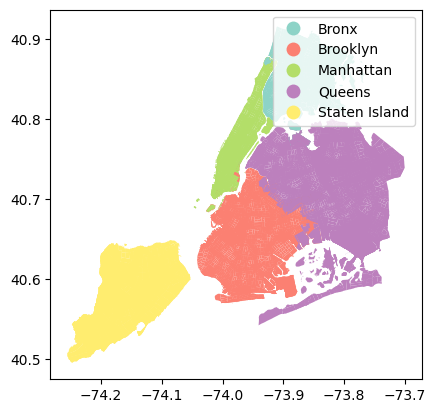

In [167]:
# setting the axes
fig, ax = plt.subplots()

# using the colormap theme "Set3" because it works well for categories
join.plot(column='borough', legend=True, cmap='Set3', ax=ax)

# Display the plot
plt.show()

I can nicely identify the 5 neighbourhoods distributed on the geometry of New York city. Staten Island in yellow, Brooklyn in red, Queens in purple, Manhattan in green and turquoise

I then plot my "poor" variable

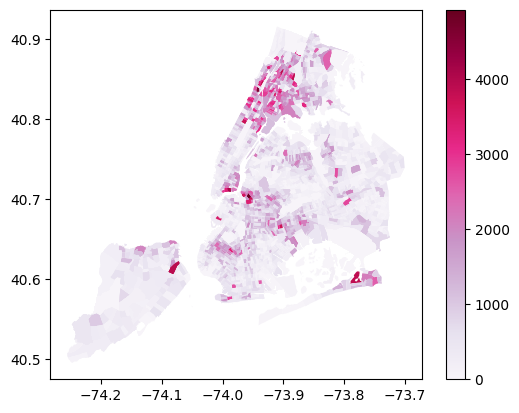

In [169]:
# setting the axes
fig, ax = plt.subplots()

join.plot(column='poor', legend=True, cmap='PuRd', ax=ax)

# Display the plot
plt.show()

I can already identify some poverty distribution, with higher values in certain areas, especially the north

I will now create a plot where I use both variables together, next to each other to explore some overlaying patterns and distribution between the two

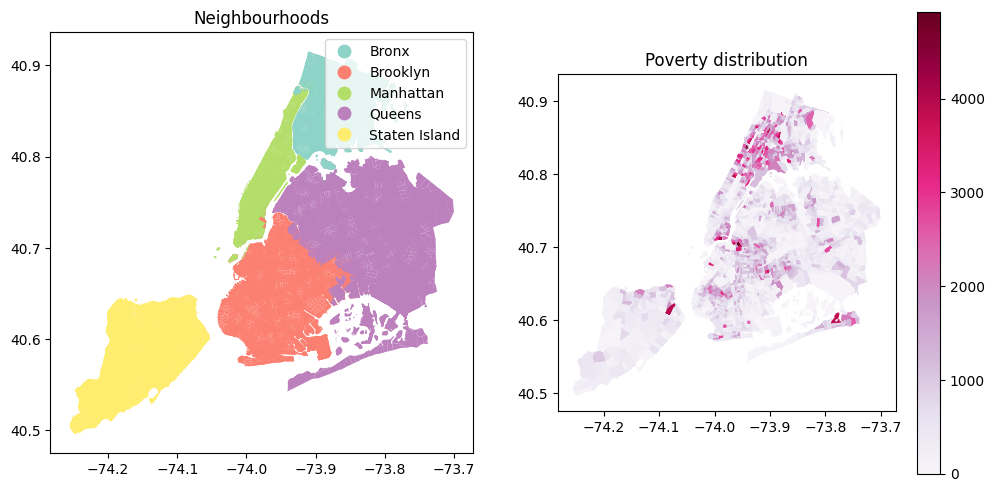

In [173]:
# setting the axes
# the 1 and 2 means that there should be 1 row and 2 columns of subplots to plot both variables next to each other
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# plotting the "borough" variable in the first subplot
# setting this subplot on the axes[0]
join.plot(column='borough', legend=True, cmap='Set3', ax=axes[0])
axes[0].set_title('Neighbourhoods')

# plotting the "poor" variable in the second subplot
# setting this subplot on the axes[1]
join.plot(column='poor', cmap='PuRd', legend=True, ax=axes[1])
axes[1].set_title('Poverty distribution')

plt.show()

Now I do a plot where I overlay them together

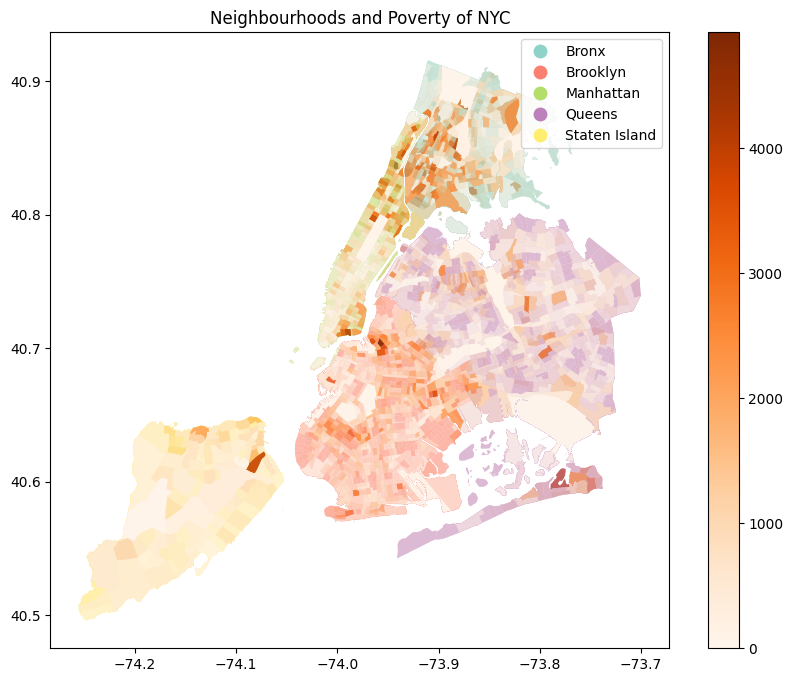

In [176]:
fig, ax = plt.subplots(figsize=(10, 8))

join.plot(column='borough', cmap='Set3', legend=True, ax=ax)

# setting alpha on 0.5 so both maps are visible
join.plot(column='poor', cmap='Oranges', legend=True, ax=ax, alpha=0.5)

ax.set_title('Neighbourhoods and Poverty of NYC')

plt.show()

With my plotted plots I can identify some patterns of the poverty distribution across the 5 neighbourhoods.
There is a clustering of high poverty in Bronx and northern Manhattan. The most high poverty distribution is in Bronx, especially towards the border to Manhattan. There are also high poverty spots in south-east Manhattan and northern Brooklyn. In Brooklyn and Queens the poor variable is more evenly distributed, with some areas higher and some lower. Especially in the south-eastern island of Queens are high poverty spots. Staten Island is the neighbourhood least affected by poverty with a rather evenly distributed low poverty rate, with only some higher and one small very high value spot in the north.

I want to get a better and more numerical understanding of the relationship between the two variables.
As I already gained some insight into their relationship through my visualizations, I now want to go a bit further. 
To visualize the distribution of the numerical "poor" variable within the "borough" variable, I will use a Boxplot.
I discorvered the Boxplot and found my information on the "https://www.geeksforgeeks.org/box-plot-visualization-with-pandas-and-seaborn/" website.

A boxplot is a graphical representation that displays the distribution of data based on summary statistics. It provides a visual summary of the central tendency, spread, and potential outliers.
With the Boxplot I want to explore the distribution of the "poor" variable across the different "borough" categories, as it provides a summary of how the values are distributed within each neighborhood group, highlighting the central tendency and spread of the data

For numerical plots, I need to make sure to remove the NaN values resulting from the join in the "borough" column, so it does not interfere with the plotting process. From my visualizations I know that "EWR" from the "borough" column will contain NaNs, because there was no data about poverty in "nyc" measured in this neighbourhood. 
So I use the "dropna" method on the join and save my cleaned join in "joincleaned"

In [178]:
# dropping the rows with NaN values in the borough column
joincleaned = join.dropna(subset=['borough'])

So, I create a boxplot with the "sns.boxplot", where I put the neighbourhood groups on the x-axis and the poor variable on the y-axis

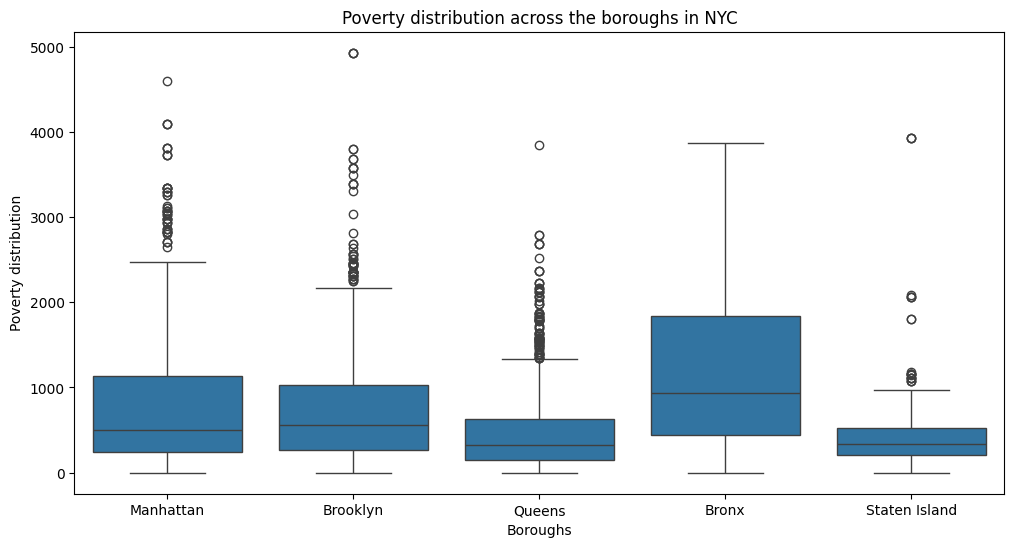

In [179]:
# creating my boxplot

plt.figure(figsize=(12, 6))

sns.boxplot(x='borough', y='poor', data=joincleaned)

plt.title('Poverty distribution across the boroughs in NYC')
plt.xlabel('Boroughs')
plt.ylabel('Poverty distribution')

plt.show()

- Bottom black horizontal line of each box plot is the minimum value
- First black horizontal line of the rectangle shape is First quartile or 25%
- Second black horizontal line of rectangle shape is the Second quartile or 50% or median
- Third black horizontal line of rectangle shape is the Third quartile or 75%
- Top black horizontal line of rectangle shape is the maximum value
- Small diamond/circle shapes of each box plot is outlier data or erroneous data


With that at hand, let me interpret the results (the numbers I extracted from the visual boxplot are approximated):

Manhattan:
   - Minimum Value: 0
   - First Quartile (25%): 300
   - Median (50%): 500
   - Third Quartile (75%): 1200
   - Maximum Value: 2500

The median value is 500, indicating that half of Manhattan has 'poor' values below 500.
Some areas in Manhattan have higher poverty with a maximum of 2500.
This shows me that there is variability and fluctuation in the poverty levels in Manhattan, with some areas not having poverty and other areas having higher levels.

Brooklyn:
   - Minimum Value: 0
   - First Quartile (25%): 350
   - Median (50%): 550
   - Third Quartile (75%): 1100
   - Maximum Value: 2200

The median value is 550 which indicates that half of Brooklyn has poor values below 550, which is a slightly higher value than Manhattan. The maximum poverty is 2200. 
Brooklyn also ehibits variability and fluctuation in the poverty levels, in a similiar range to Manhattan. However, Manhattan displays slightly higher poverty.

Queens:
   - Minimum Value: 0
   - First Quartile (25%): 200
   - Median (50%): 350
   - Third Quartile (75%): 700
   - Maximum Value: 1400

The median value is 350 which indicates that half of Queens has poor values below 350. The maximum poverty is 1400. Compared to Manhattan and Brooklyn the poverty values are generally lower with some variability in the poverty levels.

Bronx:
   - Minimum Value:
   - First Quartile (25%): 500
   - Median (50%): 950
   - Third Quartile (75%): 1800
   - Maximum Value: 3800

The median value is 950 which indicates that half of Queens has poor values below 950. The maximum poverty is 3800.
Bronx has higher poverty levels compared to all the other neighbourhoods with variability in the poverty levels.

Staten Island:
   - Minimum Value: 0
   - First Quartile (25%): 300
   - Median (50%): 350
   - Third Quartile (75%): 550
   - Maximum Value: 1000

The median value is 350 which indicates that half of Queens has poor values below 350. The maximum poverty is 1000.
In general, the poverty values with a little varrability in Staten Island appear the lowest compared to the other neighbourhoods.

This leads me to the conclusions that Queens and Staten Island generally exhibits lower poverty levels than the other neighbourhoods. Manhattan and Brooklyn show variability and fluctuation in the poverty levels, with areas experiencing low poverty and areas experiencing high poverty. And the highest poverty levels can be found in Bronx, with some areas reaching very high numbers. This relates to the distribution results that I found with my visualizations.

And finally, as a last step on my analysis on my spatial join, I want to calculate some general descriptive statistics about my variables to confirm and compare the results I found with my visualizations and my boxplot.

Therefore, I will perform "descriptive statistics" on my "poor" variable within each neighbourhood group from my "borough" variable.
For that, I use the "describe()" method that I found on the "https://datatofish.com/descriptive-statistics-pandas/" website.

In [182]:
statistics = joincleaned.groupby('borough')['poor'].describe()

print(statistics)

                count         mean         std  min    25%    50%      75%  \
borough                                                                      
Bronx           822.0  1185.729927  898.759638  0.0  443.0  932.0  1835.25   
Brooklyn       1617.0   733.334570  644.490357  0.0  264.0  561.0  1027.00   
Manhattan       796.0   837.481156  850.586177  0.0  238.0  507.0  1133.00   
Queens         1464.0   472.788934  478.569695  0.0  148.0  327.0   626.00   
Staten Island   293.0   456.972696  497.578684  0.0  206.0  338.0   530.00   

                  max  
borough                
Bronx          3869.0  
Brooklyn       4928.0  
Manhattan      4600.0  
Queens         3850.0  
Staten Island  3925.0  


The result provides me various summary statistics on the "poor" variable for each neighbourhood including count, mean, standard deviation, minimum, the 25% percentile, the 50% percentile (aka median), 75% percentile, and maximum.

I will now explore some of these results, that I see as most valuable in my analysis :

By comparing the mean value of the boroughs, I can see that the Bronx mean is higher that the other boroughs.
This tells me that on average, Bronx has a higher level of poverty compared to the other boroughs.
Staten Island has the lowest mean indicating that it has on average a lower poverty than the other neighborhoods. Followed by Queens, then Brooklyn and then Manhattan.

By comparing the standard deviation "std" of the boroughs, I can see that Bronx also has the highest value in this category.
This tells me that there is greater diversity and fluctuation in poverty levels among the different areas of Bronx. Manhattan also has a high fluctuation in poverty levels, with a "std" close to Bronx. Brooklyn has a medium high poverty level fluctuation and Staten Island and Queens have a lower one compared to the other boroughs, with Queens having the lowest fluctuation.

By comparing the maximum "max" of the boroughs, I can see that Brooklyn has the highest one. 
This tells me that the highest observed poverty level of someone can be found in Brooklyn, compared to the other boroughs.

These observations nicely support my interpretation and results from my visualizations and the boxplot.